# 0. Import the libraries

In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from IPython.core.display import HTML
from IPython.display import display
from pandas_profiling import ProfileReport
from pathlib import Path
from scipy.stats import probplot, chi2_contingency, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from imblearn.over_sampling import SMOTE
import joblib
import os
import pickle
import streamlit as st
#from scipy.stats import norm
%matplotlib inline

# 1. Frame the problem and look at the big picture

## 1.1 Define the objective in business terms.

Determine if the income of a person is greater or less than 50k

## 1.2 How will your solution be used?

The solution can be use in the bank industry for loan applications, it could also be use at the dearship for a car financing.

## 1.3 What are the current solutions/workarounds (if any)?

Not applicable

## 1.4 How should you frame this problem (supervised/unsupervised, online/offline, etc.)

Supervised Learning, Batch learning, Model-based learning.

## 1.5 How should performance be measured?

Classification metrics which are: Accuracy score, Confustion matrix, Classification report, Precision, Recall, F1 score, ROC curve, AUC, Precision-Recall curve

## 1.6 Is the performance measure aligned with the business objective?

Not applicable

## 1.7 What would be the minimum performance needed to reach the business objective?

A subjective accuracy of more than 80%.

## 1.8 What are comparable problems? Can you reuse experience or tools?

Not applicable

## 1.9 Is human expertise available?

No

## 1.10 How would you solve the problem manually?

By looking at each person information and determine if they have an income higher than 50K which is a tedious task.

## 1.11 List the assumptions you or others have made so far.

Some of the assumptions would be that education, occupation, race , gender and native country might influence the target. To be verified

## 1.12 Verify assumptions if possible.

To be verified

# 2. Get the data

## 2.1 List the data you need and how much you need.

Will use the data from the train and test datasets.

## 2.2 Find and document where you can get that data.

Done!

## 2.3 Check how much space it will take.

less than 5 Megabytes.

## 2.4 Check legal obligations, and get the authorization if necessary.

Not applicable

## 2.5 Get access authorizations.

Not applicable

## 2.6 Create a workspace (with enough storage space).

No need

## 2.7 Get the data.

In [2]:
train_original = pd.read_csv('datasets/train.csv')

## 2.8 Convert the data to a format you can easily manipulate (without changing the data itself).

Data already in a good format

## 2.9 Ensure sensitive information is deleted or protected (e.g., anonymized).

Not applicable

## 2.10 Check the size and type of data (time series, sample, geographical, etc.).

~ 5 MB of tabular data

## 2.11 Sample a test set, put it aside, and never look at it (no data snooping!).

In [3]:
test_original = pd.read_csv('datasets/test.csv')

In [4]:
full_data = pd.concat([train_original, test_original], axis=0)

In [5]:
# shuffle the data
full_data = full_data.sample(frac=1).reset_index(drop=True)

In [6]:
full_data.shape

(44856, 15)

In [7]:
# split the data into train and test
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [8]:
train_original, test_original = data_split(full_data, 0.2)

In [9]:
train_original.shape

(35884, 15)

In [10]:
test_original.shape

(8972, 15)

In [11]:
train_copy = train_original.copy()
test_copy = test_original.copy()

# 3. Explore the data

## 3.1 Create a copy of the data for exploration (sampling it down to a manageable size if necessary).

Not necessary

## 3.2 Create a Jupyter notebook to keep record of your data exploration.

Done!

## 3.3 Quick overview of the data

In [12]:
train_copy.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income_>50K
0,37,Federal-gov,325538,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,NaN,1.0
1,21,Private,455361,9th,5,Never-married,Other-service,Unmarried,White,Male,0,0,35,Mexico,0.0
2,22,Private,52262,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,45,United-States,0.0
3,48,Local-gov,189762,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,1.0
4,37,Self-emp-inc,257295,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,0,0,75,Thailand,NaN


In [13]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35884 entries, 0 to 35883
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              35884 non-null  int64  
 1   workclass        33908 non-null  object 
 2   fnlwgt           35884 non-null  int64  
 3   education        35884 non-null  object 
 4   educational-num  35884 non-null  int64  
 5   marital-status   35884 non-null  object 
 6   occupation       33901 non-null  object 
 7   relationship     35884 non-null  object 
 8   race             35884 non-null  object 
 9   gender           35884 non-null  object 
 10  capital-gain     35884 non-null  int64  
 11  capital-loss     35884 non-null  int64  
 12  hours-per-week   35884 non-null  int64  
 13  native-country   35257 non-null  object 
 14  income_>50K      35178 non-null  float64
dtypes: float64(1), int64(6), object(8)
memory usage: 4.1+ MB


In [14]:
train_copy.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,income_>50K
count,35884.000000,3.588400e+04,35884.000000,35884.000000,35884.000000,35884.000000,35178.000000
mean,38.671971,1.897708e+05,10.090793,1093.010952,88.705997,40.485342,0.240292
std,13.736270,1.060092e+05,2.573384,7583.324264,406.337953,12.424802,0.427267
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.172525e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.779530e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.379968e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


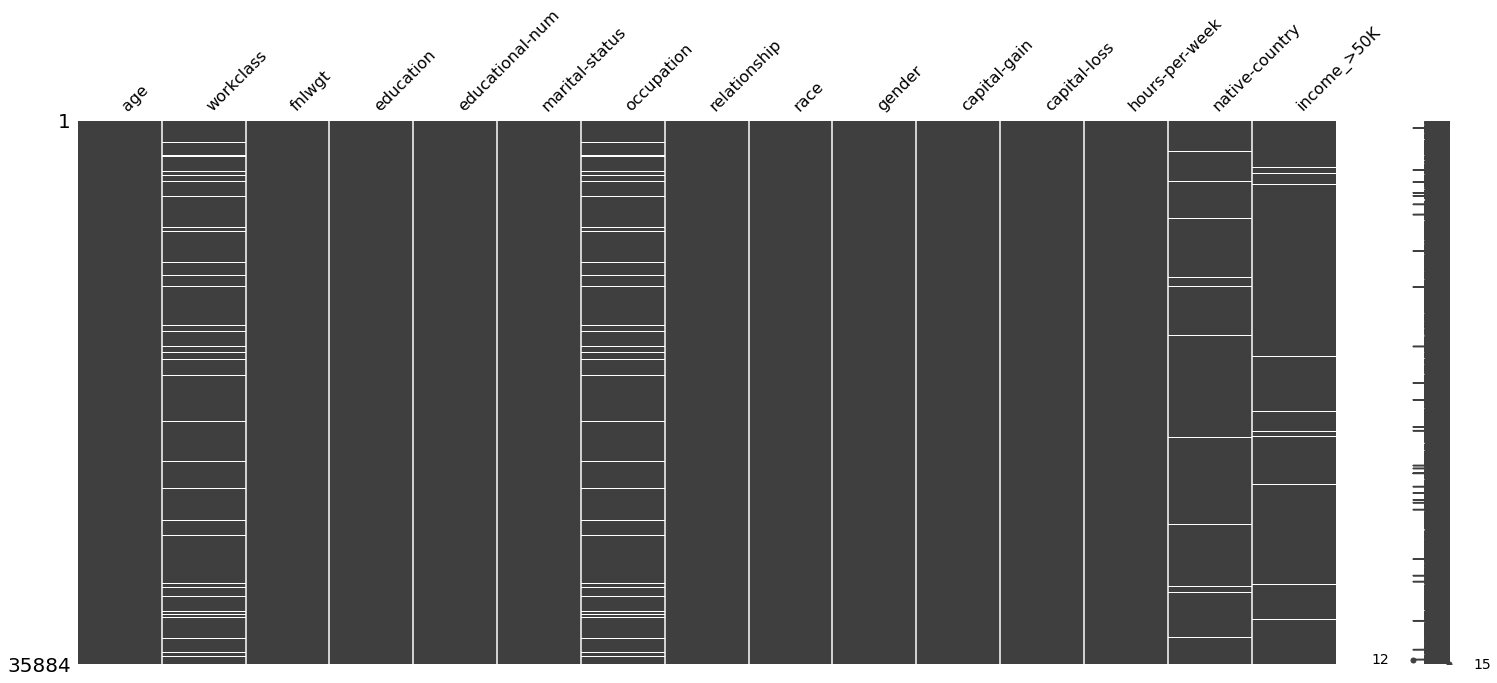

In [15]:
msno.matrix(train_copy)
plt.show()

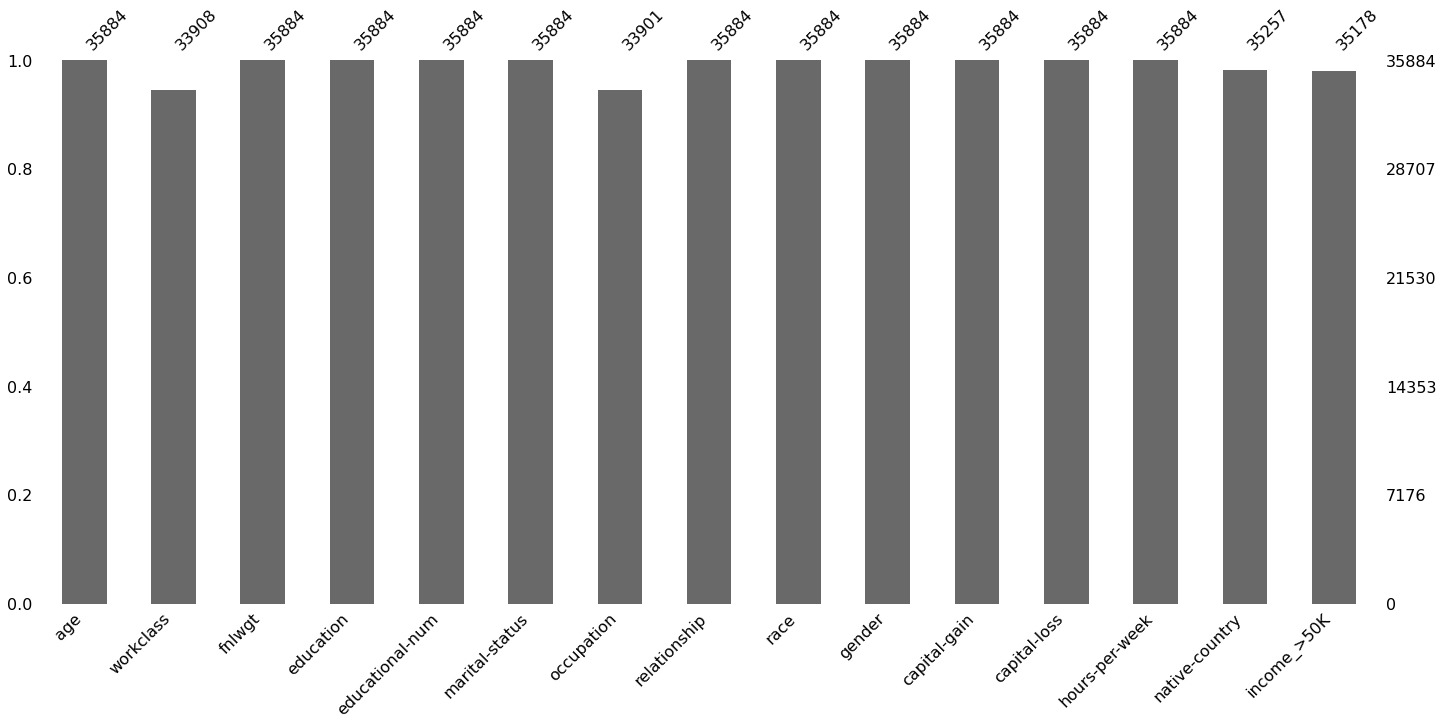

In [16]:
msno.bar(train_copy)
plt.show()

In [17]:
#profile_report = ProfileReport(train_copy, explorative=True, dark_mode=True)

In [18]:
profile_report_file_path = Path('income_class_profile.html')

try:
    profile_report_file_path.resolve(strict=True)
except FileNotFoundError:
    profile_report.to_file("income_class_profile.html")
else:
    pass

## 3.4 Study each attribute and its characteristics:
## - Name
## - Type (categorical, int/float, bounded/unbounded, text, structured, etc.)
## - % of missing values
## - Noisiness and type of noise (stochastic, outliers, rounding errors, etc.)
## - Possibly useful for the task?
## - Type of distribution (Gaussian, uniform, logarithmic, etc.)

In [19]:
#Function that will return the value count and frequency of each observation within a column
def value_cnt_norm_cal(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

### 3.4.1 Age

In [20]:
train_copy['age'].head()

0    37
1    21
2    22
3    48
4    37
Name: age, dtype: int64

In [21]:
train_copy['age'].describe()

count    35884.000000
mean        38.671971
std         13.736270
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64

In [22]:
train_copy['age'].dtype

dtype('int64')

In [23]:
train_copy['age'].isnull().sum()

0

In [24]:
age_value_cnt_norm = train_copy['age'].value_counts(normalize=True) * 100

In [25]:
age_value_cnt = train_copy['age'].value_counts()

In [26]:
value_cnt_norm_cal(train_copy, 'age')

,Count,Frequency (%)
33,997,2.778397
31,990,2.758890
36,985,2.744956
34,967,2.694794
23,964,2.686434
...,...,...
88,6,0.016721
85,4,0.011147
89,2,0.005574
87,2,0.005574


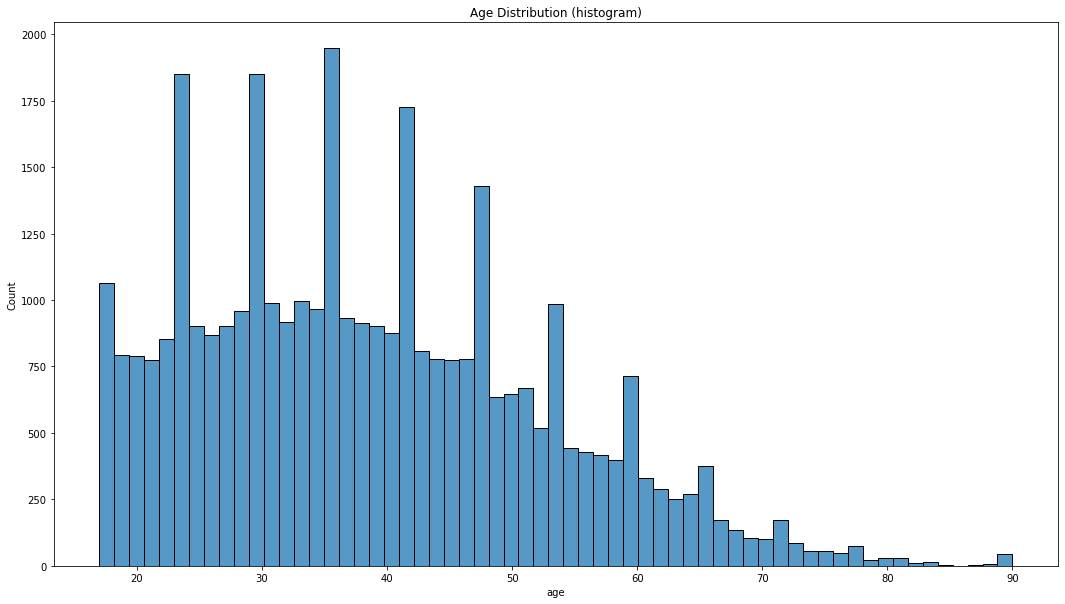

In [27]:
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(train_copy['age'])
plt.title('Age Distribution (histogram)')
plt.show()

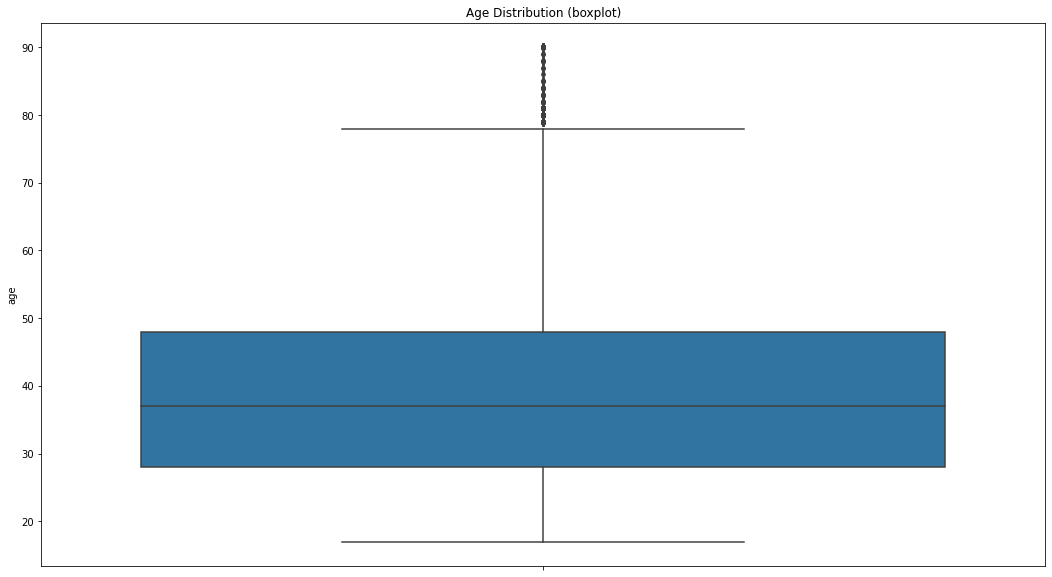

In [28]:
fig, ax = plt.subplots(figsize=(18,10))
sns.boxplot(y=train_copy['age'])
plt.title('Age Distribution (boxplot)')
plt.show()

In [29]:
# TODO: Age is might be useful for the model, will keep it for now

### 3.4.2 Workclass

In [30]:
train_copy['workclass'].dtype

dtype('O')

In [31]:
train_copy['workclass'].head()

0     Federal-gov
1         Private
2         Private
3       Local-gov
4    Self-emp-inc
Name: workclass, dtype: object

In [32]:
value_cnt_norm_cal(train_copy,'workclass')

,Count,Frequency (%)
Private,24950,73.581456
Self-emp-not-inc,2874,8.475876
Local-gov,2306,6.800755
State-gov,1428,4.211396
Self-emp-inc,1268,3.739530
Federal-gov,1059,3.123157
Without-pay,16,0.047187
Never-worked,7,0.020644


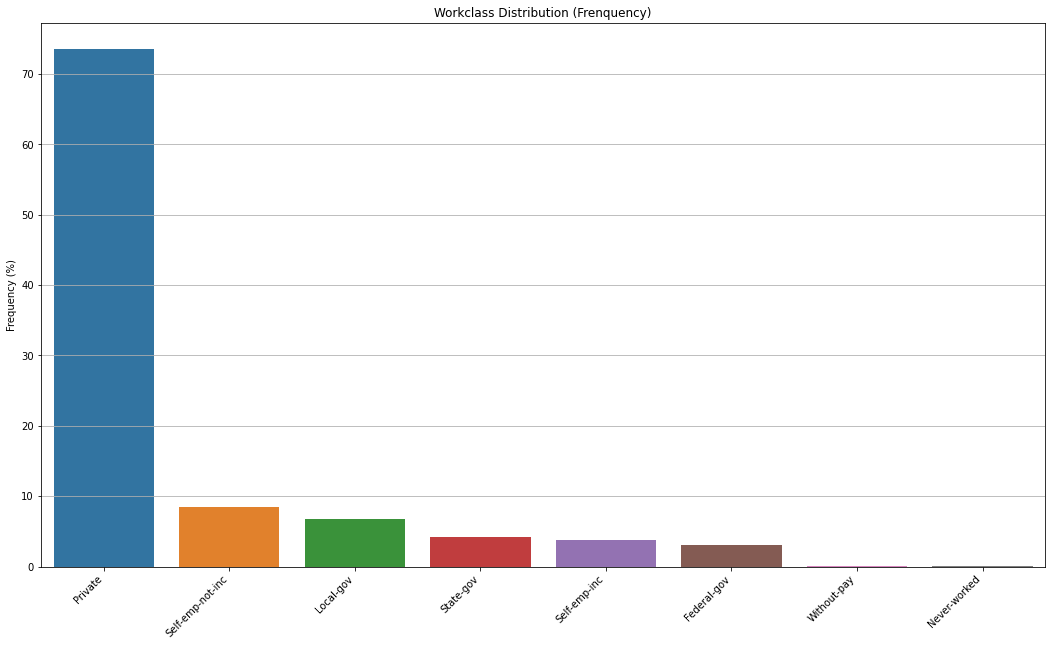

In [33]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'workclass').index, y=value_cnt_norm_cal(train_copy,'workclass')['Frequency (%)'])
plt.title('Workclass Distribution (Frenquency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

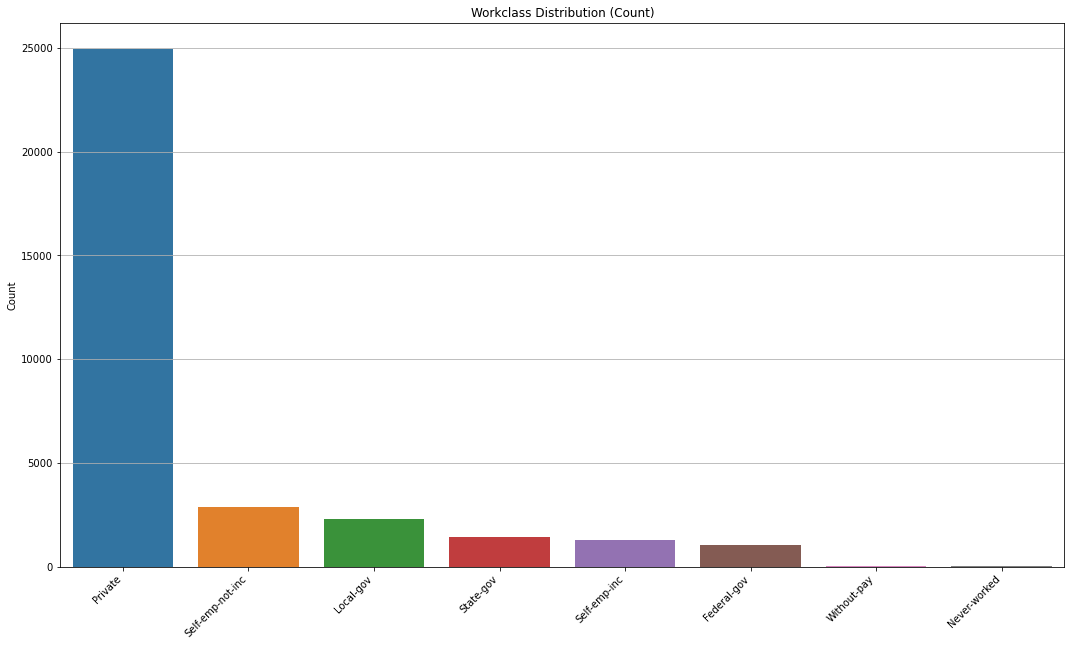

In [34]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'workclass').index, y=value_cnt_norm_cal(train_copy,'workclass')['Count'])
plt.title('Workclass Distribution (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

In [35]:
train_copy['workclass'].isnull().sum()

1976

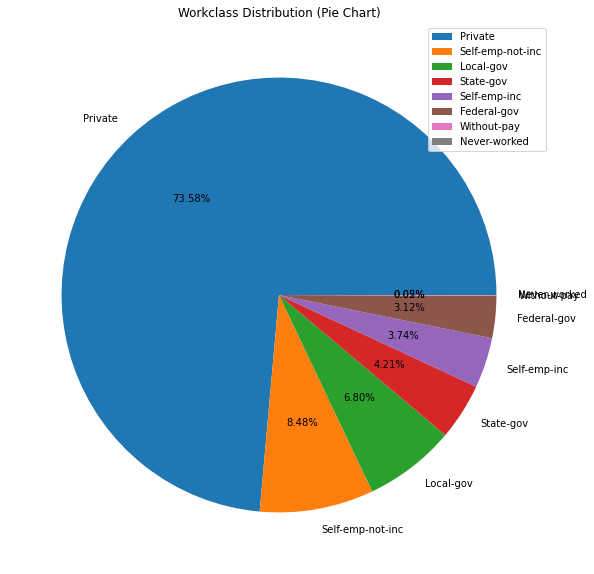

In [36]:
fig, ax = plt.subplots(figsize=(18,10))
plt.pie(train_copy['workclass'].value_counts(), labels=train_copy['workclass'].value_counts().index, autopct='%1.2f%%')
plt.title('Workclass Distribution (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

In [37]:
# TODO: workclass is might be useful for the model, will keep it for now

### 3.4.3 Final weight

Its a weight assigned by the Census Bureau. **The idea is that if two samples have the same(or similar) fnlwgt they have similar characteristics, demographically speaking. **Say sample 7,12 and 33 are having similar fnlwgt values they are more likely to be of the same race, similar educational and social background, etc.. but if you are planning to use it, you should be aware that they are not standardized across different states/country. So someone in one country might share similar fnlwgt with somebody in another country but might have entirely different socio-economic background.

In [38]:
train_copy['fnlwgt'].dtype

dtype('int64')

In [39]:
train_copy['fnlwgt'].head()

0    325538
1    455361
2     52262
3    189762
4    257295
Name: fnlwgt, dtype: int64

In [40]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train_copy['fnlwgt'].describe()

count     35884.000
mean     189770.769
std      106009.175
min       13492.000
25%      117252.500
50%      177953.000
75%      237996.750
max     1484705.000
Name: fnlwgt, dtype: float64

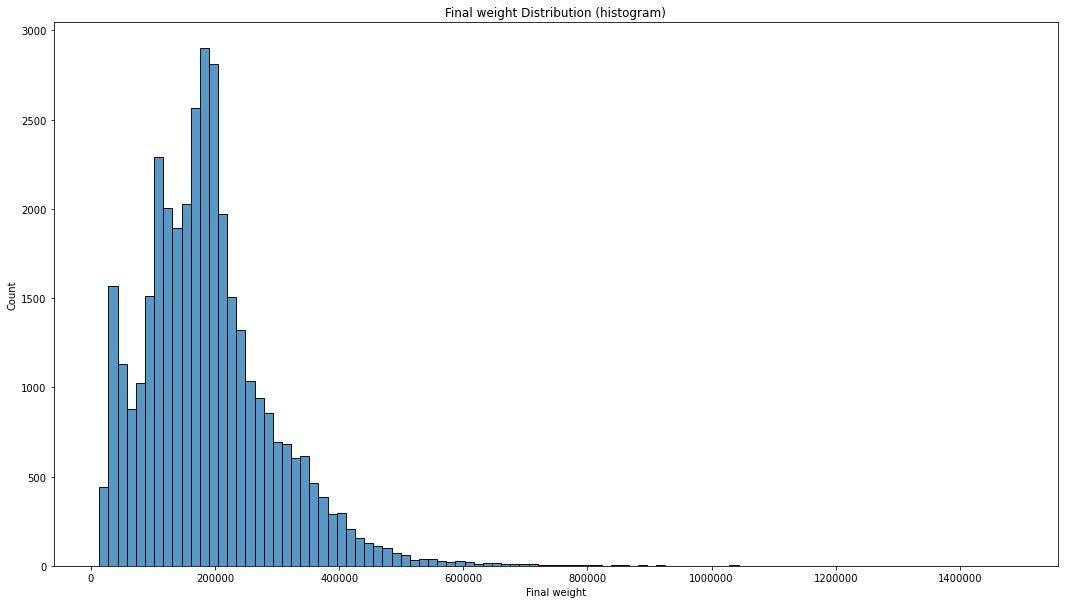

In [41]:
fig, ax = plt.subplots(figsize=(18,10))
ax.ticklabel_format(style='plain')
sns.histplot(train_copy['fnlwgt'],bins=100)
plt.title('Final weight Distribution (histogram)')
plt.xlabel('Final weight')
plt.show()

In [42]:
# TODO: Not sure if this feature is useful, will keep it for now. Will run the feature im and see if this is useful

### 3.4.4. Education

In [43]:
train_copy['education'].dtype

dtype('O')

In [44]:
train_copy['education'].head()

0         Masters
1             9th
2    Some-college
3         HS-grad
4    Some-college
Name: education, dtype: object

In [45]:
train_copy['education'].isnull().sum()

0

In [46]:
value_cnt_norm_cal(train_copy,'education')

,Count,Frequency (%)
HS-grad,11586,32.287
Some-college,7994,22.277
Bachelors,5924,16.509
Masters,1980,5.518
Assoc-voc,1480,4.124
11th,1347,3.754
Assoc-acdm,1199,3.341
10th,982,2.737
7th-8th,699,1.948
Prof-school,605,1.686


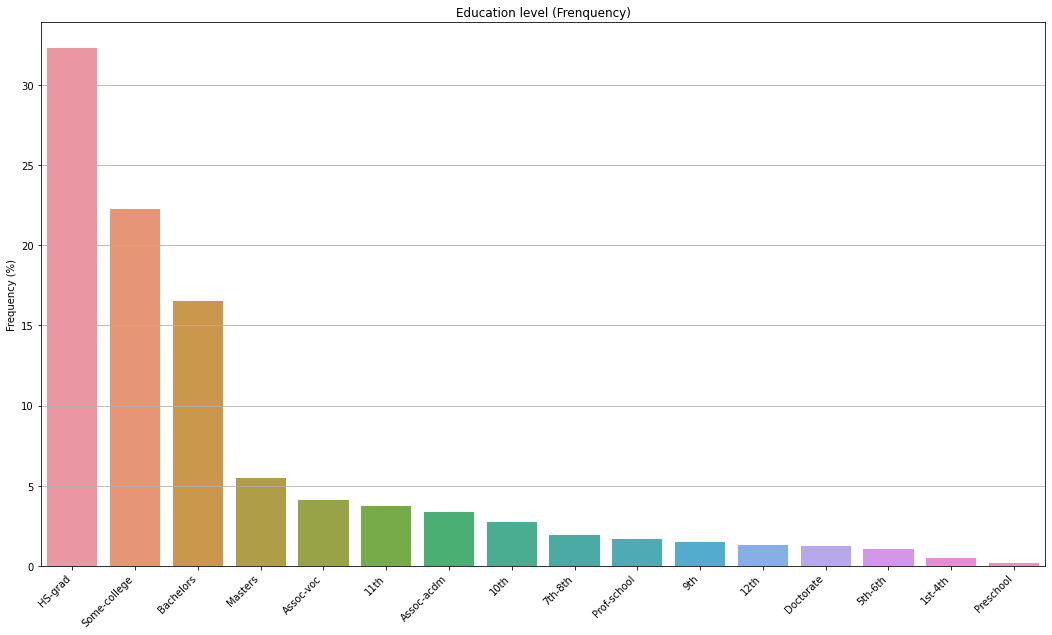

In [47]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'education').index, y=value_cnt_norm_cal(train_copy,'education')['Frequency (%)'])
plt.title('Education level (Frenquency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

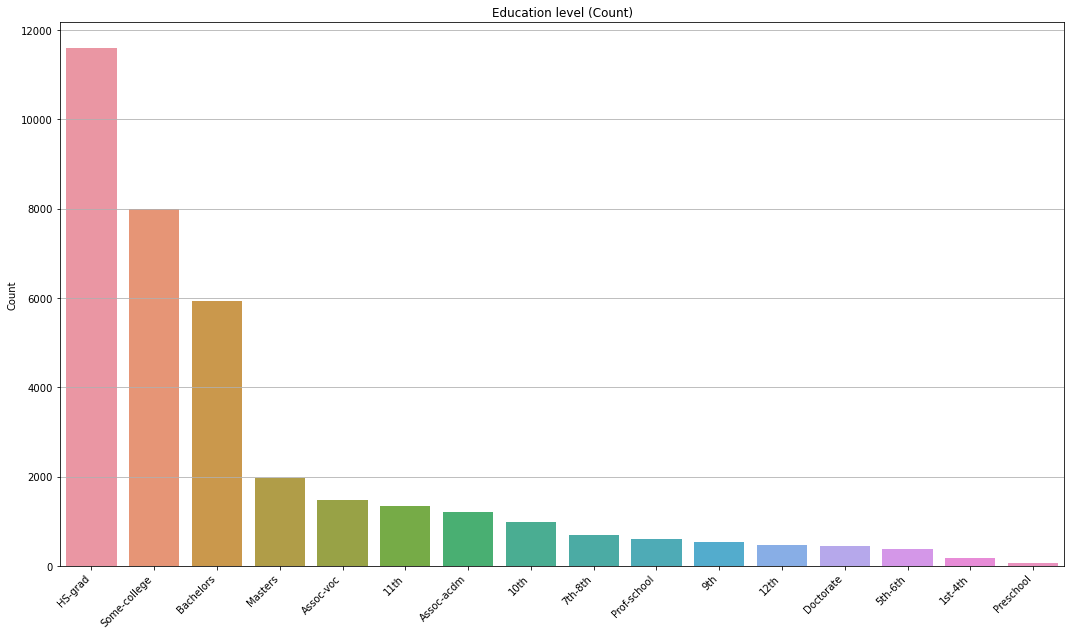

In [48]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'education').index, y=value_cnt_norm_cal(train_copy,'education')['Count'])
plt.title('Education level (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

In [49]:
# TODO: education level is might be useful for the model, will keep it for now

### 3.4.5 education number

In [50]:
train_copy['educational-num'].dtype

dtype('int64')

In [51]:
train_copy['educational-num'].head()

0    14
1     5
2    10
3     9
4    10
Name: educational-num, dtype: int64

In [52]:
train_copy['educational-num'].value_counts()

9     11586
10     7994
13     5924
14     1980
11     1480
7      1347
12     1199
6       982
4       699
15      605
5       543
8       468
16      454
3       385
2       176
1        62
Name: educational-num, dtype: int64

In [53]:
train_copy[['education','educational-num']].nunique()

education          16
educational-num    16
dtype: int64

In [54]:
train_copy[['education','educational-num']].value_counts()

education     educational-num
HS-grad       9                  11586
Some-college  10                  7994
Bachelors     13                  5924
Masters       14                  1980
Assoc-voc     11                  1480
11th          7                   1347
Assoc-acdm    12                  1199
10th          6                    982
7th-8th       4                    699
Prof-school   15                   605
9th           5                    543
12th          8                    468
Doctorate     16                   454
5th-6th       3                    385
1st-4th       2                    176
Preschool     1                     62
dtype: int64

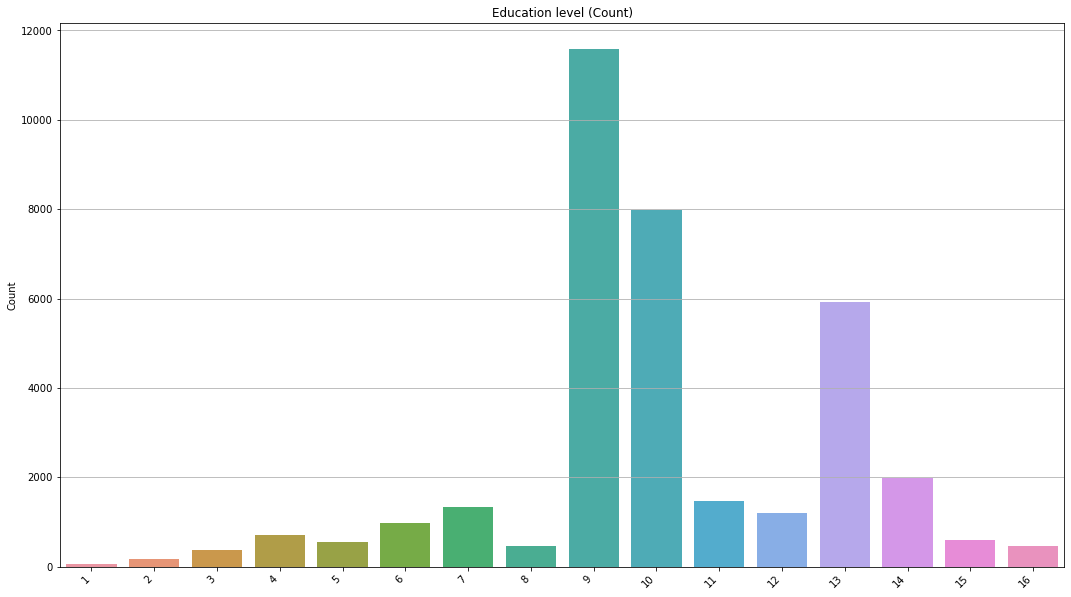

In [55]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'educational-num').index, y=value_cnt_norm_cal(train_copy,'educational-num')['Count'])
plt.title('Education level (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

In [56]:
# TODO: since education-num is essentially an encoded version of education, will need to drop this feature and keep education for now.

### 3.4.6 Marital Status

In [57]:
train_copy['marital-status'].dtype

dtype('O')

In [58]:
train_copy['marital-status'].head()

0    Married-civ-spouse
1         Never-married
2    Married-civ-spouse
3    Married-civ-spouse
4    Married-civ-spouse
Name: marital-status, dtype: object

In [59]:
train_copy['marital-status'].isnull().sum()

0

In [60]:
value_cnt_norm_cal(train_copy,'marital-status')

,Count,Frequency (%)
Married-civ-spouse,16477,45.917
Never-married,11778,32.822
Divorced,4909,13.680
Widowed,1125,3.135
Separated,1124,3.132
Married-spouse-absent,445,1.240
Married-AF-spouse,26,0.072


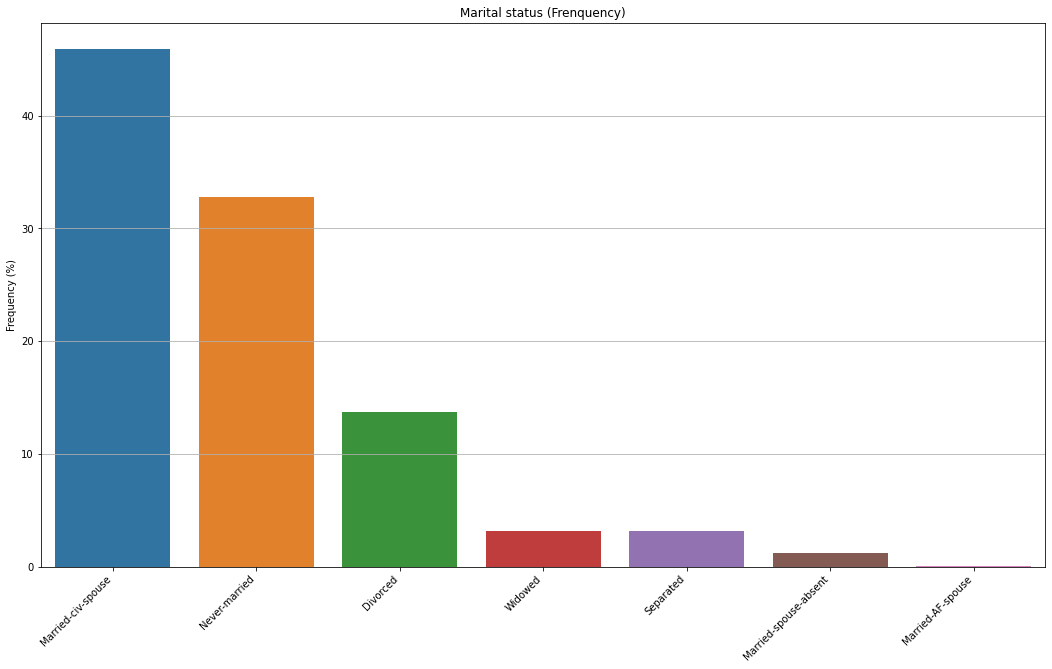

In [61]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'marital-status').index, y=value_cnt_norm_cal(train_copy,'marital-status')['Frequency (%)'])
plt.title('Marital status (Frenquency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

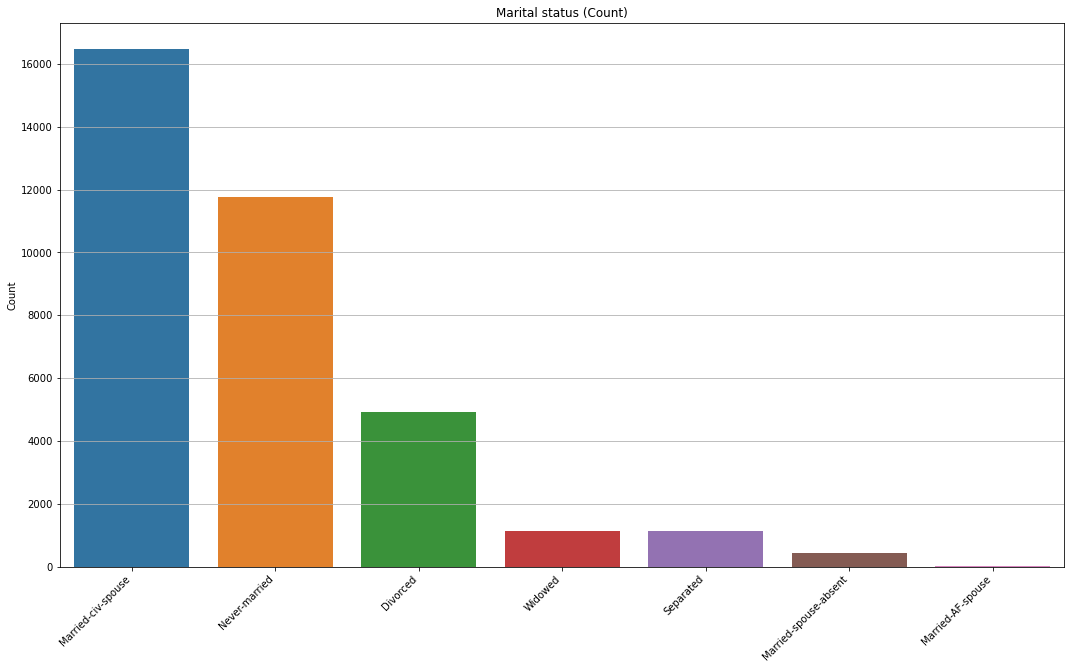

In [62]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'marital-status').index, y=value_cnt_norm_cal(train_copy,'marital-status')['Count'])
plt.title('Marital status (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

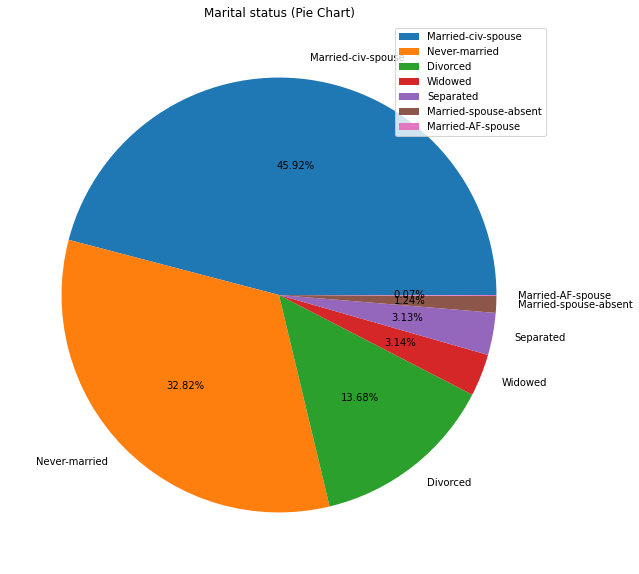

In [63]:
fig, ax = plt.subplots(figsize=(18,10))
plt.pie(train_copy['marital-status'].value_counts(), labels=train_copy['marital-status'].value_counts().index, autopct='%1.2f%%')
plt.title('Marital status (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

### 3.4.7 Occupation

In [64]:
train_copy['occupation'].dtype

dtype('O')

In [65]:
train_copy['occupation'].head()

0     Prof-specialty
1      Other-service
2              Sales
3       Craft-repair
4    Exec-managerial
Name: occupation, dtype: object

In [66]:
train_copy['occupation'].isnull().sum()

1983

In [67]:
train_copy['occupation'].value_counts()

Prof-specialty       4565
Craft-repair         4519
Exec-managerial      4471
Adm-clerical         4112
Sales                4061
Other-service        3599
Machine-op-inspct    2236
Transport-moving     1735
Handlers-cleaners    1512
Farming-fishing      1100
Tech-support         1085
Protective-serv       720
Priv-house-serv       175
Armed-Forces           11
Name: occupation, dtype: int64

In [68]:
train_copy['occupation'].nunique()

14

In [69]:
value_cnt_norm_cal(train_copy,'occupation')

,Count,Frequency (%)
Prof-specialty,4565,13.466
Craft-repair,4519,13.330
Exec-managerial,4471,13.188
Adm-clerical,4112,12.129
Sales,4061,11.979
Other-service,3599,10.616
Machine-op-inspct,2236,6.596
Transport-moving,1735,5.118
Handlers-cleaners,1512,4.460
Farming-fishing,1100,3.245


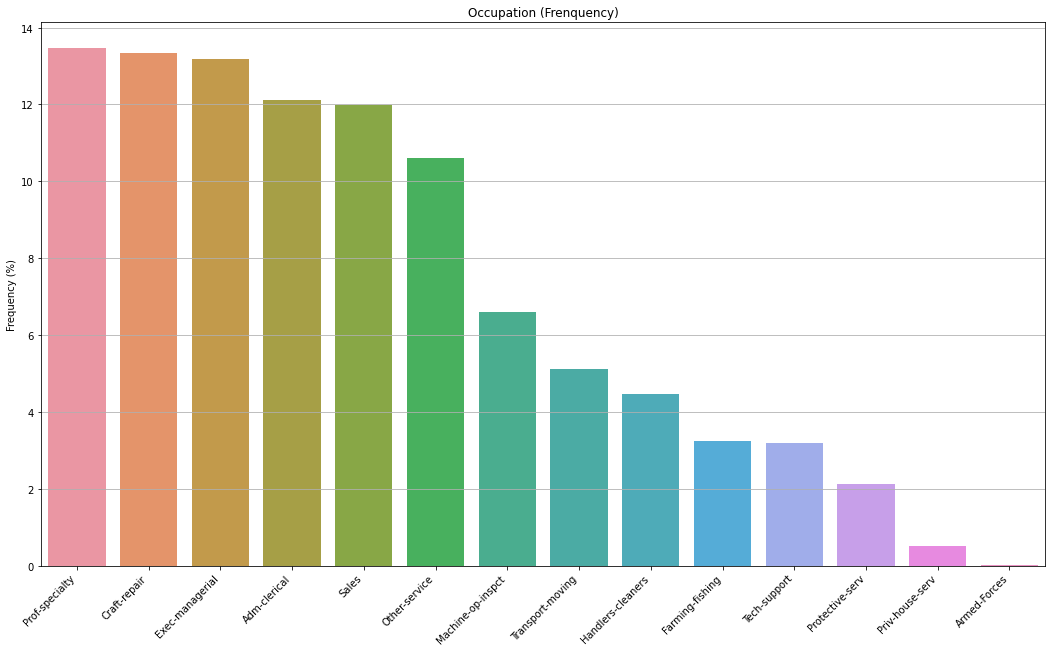

In [70]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'occupation').index, y=value_cnt_norm_cal(train_copy,'occupation')['Frequency (%)'])
plt.title('Occupation (Frenquency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

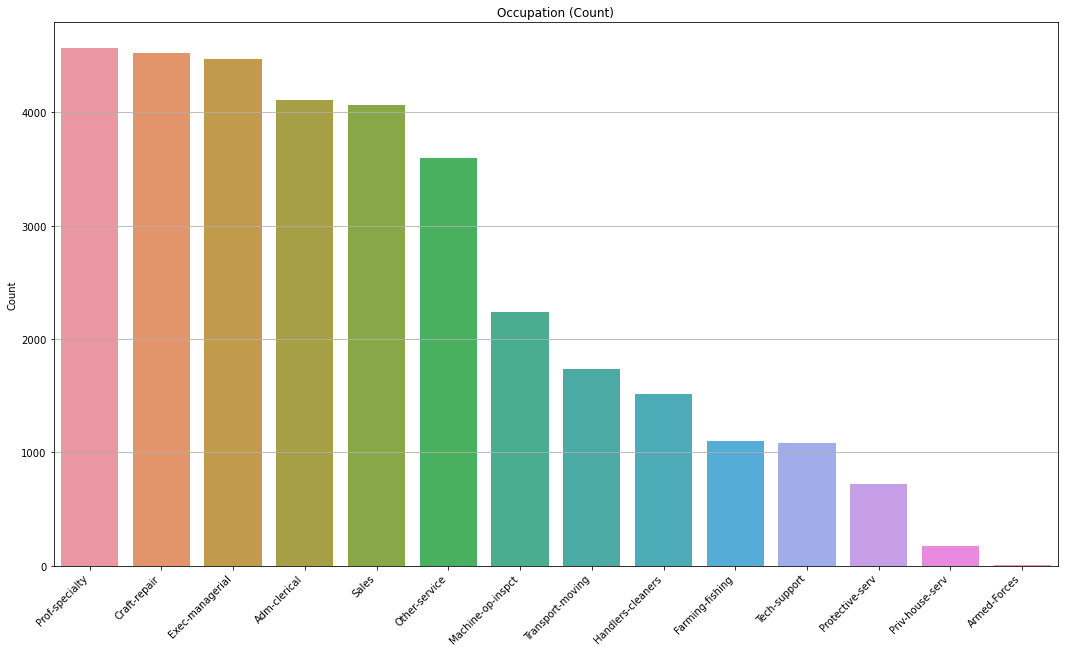

In [71]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'occupation').index, y=value_cnt_norm_cal(train_copy,'occupation')['Count'])
plt.title('Occupation (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

In [72]:
## TODO: occupation is highly correlated with workclass, has almost the same missing value like workclass and gives less info than workclass. we might need to drop this feature.

### 3.4.8 relationship

In [73]:
train_copy['relationship'].dtype

dtype('O')

In [74]:
train_copy['relationship'].head()

0      Husband
1    Unmarried
2      Husband
3      Husband
4      Husband
Name: relationship, dtype: object

In [75]:
train_copy['relationship'].value_counts()

Husband           14506
Not-in-family      9283
Own-child          5513
Unmarried          3777
Wife               1727
Other-relative     1078
Name: relationship, dtype: int64

In [76]:
train_copy['relationship'].isnull().sum()

0

In [77]:
value_cnt_norm_cal(train_copy,'relationship')

,Count,Frequency (%)
Husband,14506,40.425
Not-in-family,9283,25.869
Own-child,5513,15.363
Unmarried,3777,10.526
Wife,1727,4.813
Other-relative,1078,3.004


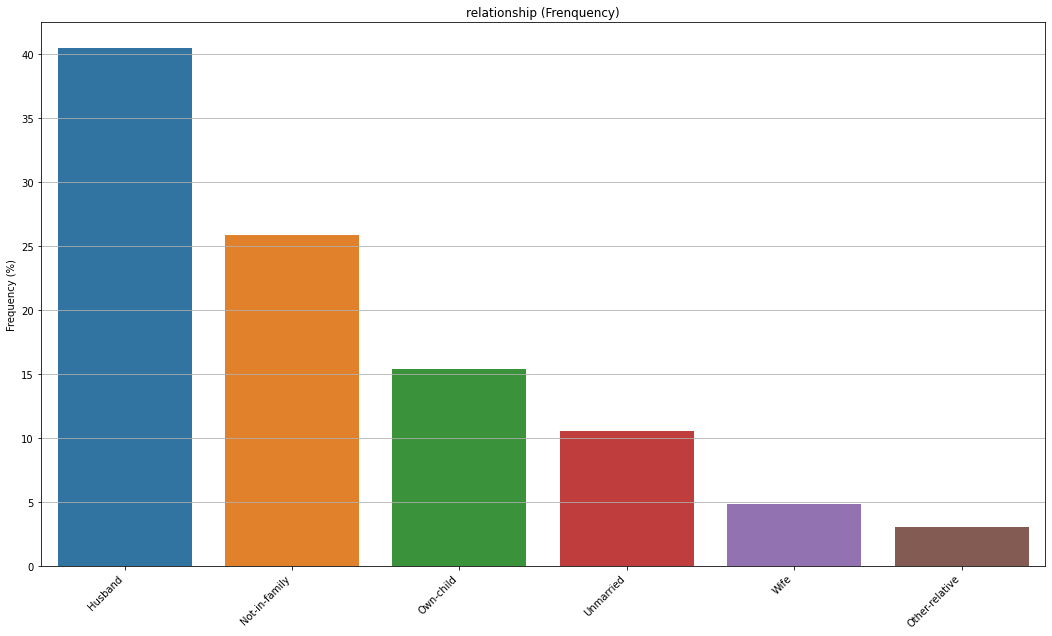

In [78]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'relationship').index, y=value_cnt_norm_cal(train_copy,'relationship')['Frequency (%)'])
plt.title('relationship (Frenquency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

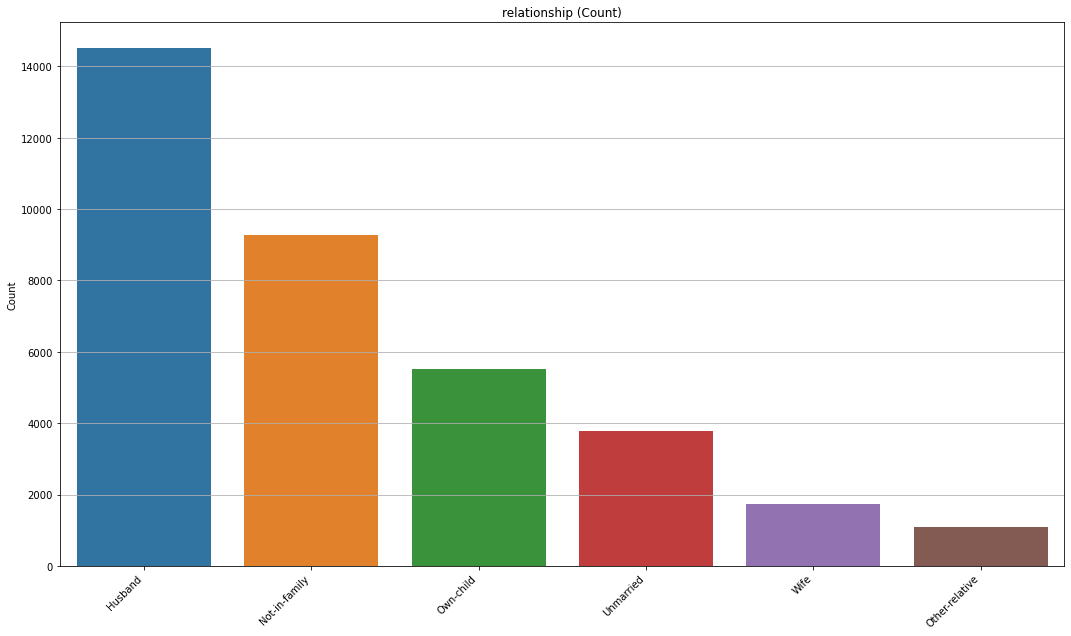

In [79]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'relationship').index, y=value_cnt_norm_cal(train_copy,'relationship')['Count'])
plt.title('relationship (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

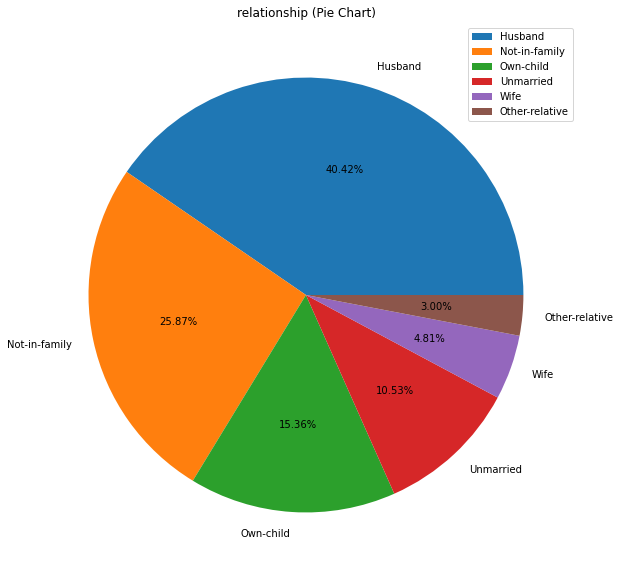

In [80]:
fig, ax = plt.subplots(figsize=(18,10))
plt.pie(train_copy['relationship'].value_counts(), labels=train_copy['relationship'].value_counts().index, autopct='%1.2f%%')
plt.title('relationship (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

In [81]:
# TODO: relationship is highly correlated with Marital status. we might need to drop this feature.

### 3.4.9 Race

In [82]:
train_copy['race'].dtype

dtype('O')

In [83]:
train_copy['race'].isnull().sum()

0

In [84]:
train_copy['race'].head()

0                 White
1                 White
2                 White
3                 White
4    Asian-Pac-Islander
Name: race, dtype: object

In [85]:
value_cnt_norm_cal(train_copy,'race')

,Count,Frequency (%)
White,30659,85.439
Black,3460,9.642
Asian-Pac-Islander,1118,3.116
Amer-Indian-Eskimo,336,0.936
Other,311,0.867


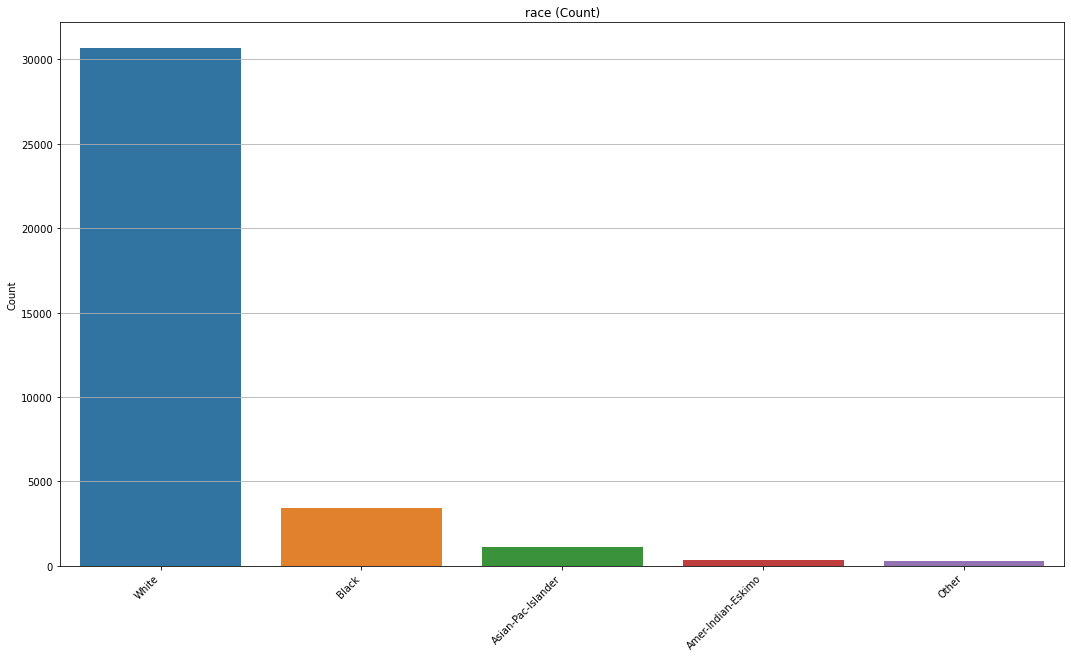

In [86]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'race').index, y=value_cnt_norm_cal(train_copy,'race')['Count'])
plt.title('race (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

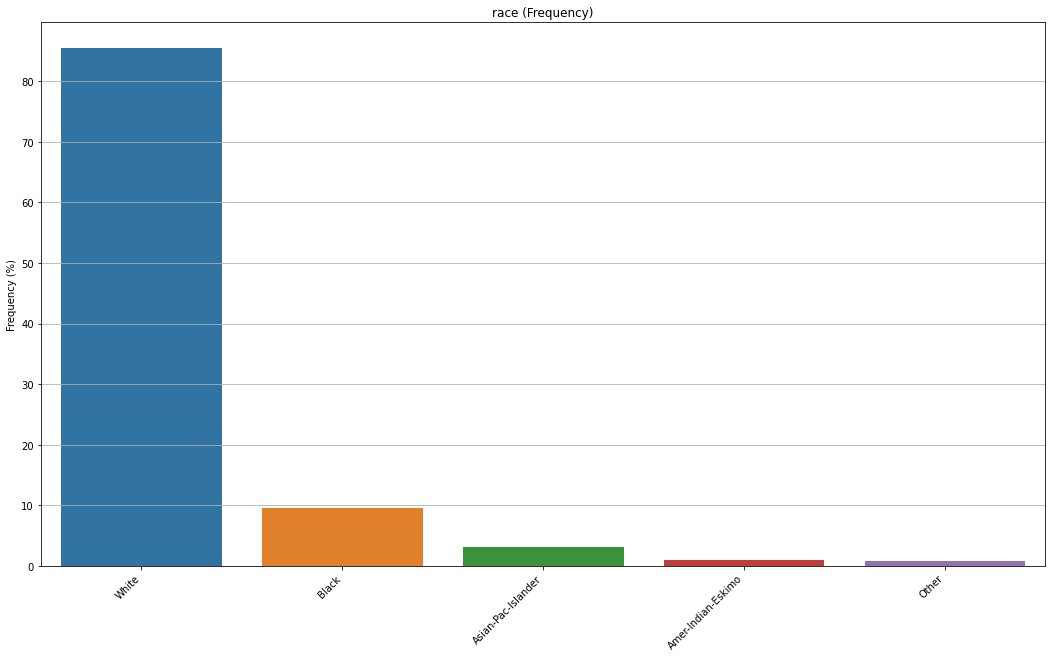

In [87]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'race').index, y=value_cnt_norm_cal(train_copy,'race')['Frequency (%)'])
plt.title('race (Frequency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

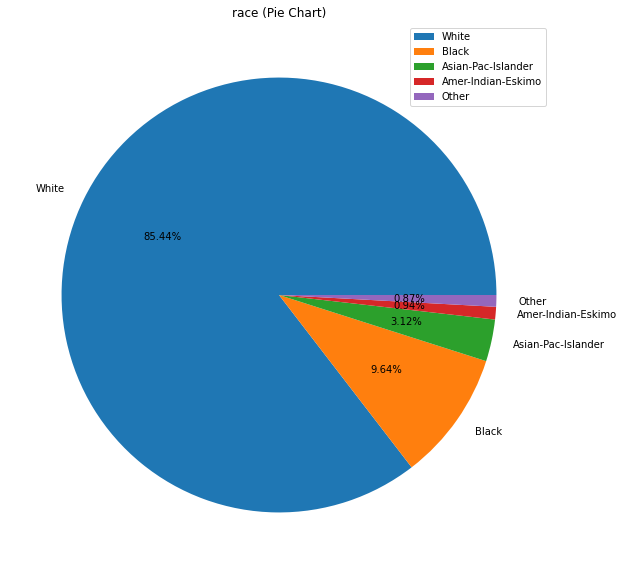

In [88]:
fig, ax = plt.subplots(figsize=(18,10))
plt.pie(train_copy['race'].value_counts(), labels=train_copy['race'].value_counts().index, autopct='%1.2f%%')
plt.title('race (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

In [89]:
# TODO: Race might influence on the salary. will keep it

### 3.4.10 Gender

In [90]:
train_copy['gender'].dtype

dtype('O')

In [91]:
train_copy['race'].isnull().sum()

0

In [92]:
value_cnt_norm_cal(train_copy,'gender')

,Count,Frequency (%)
Male,24017,66.930
Female,11867,33.070


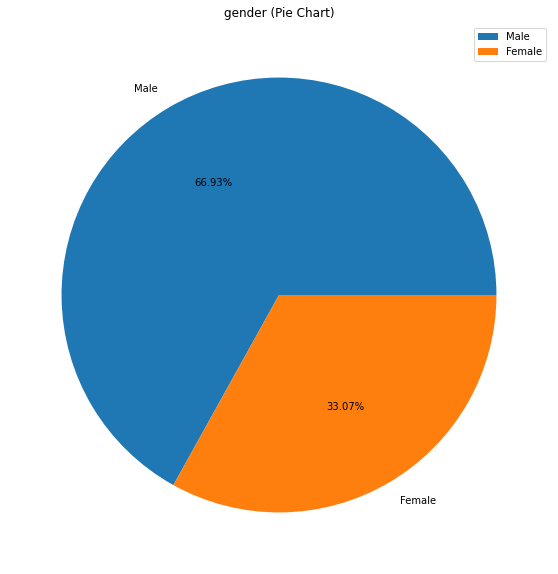

In [93]:
fig, ax = plt.subplots(figsize=(18,10))
plt.pie(train_copy['gender'].value_counts(), labels=train_copy['gender'].value_counts().index, autopct='%1.2f%%')
plt.title('gender (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

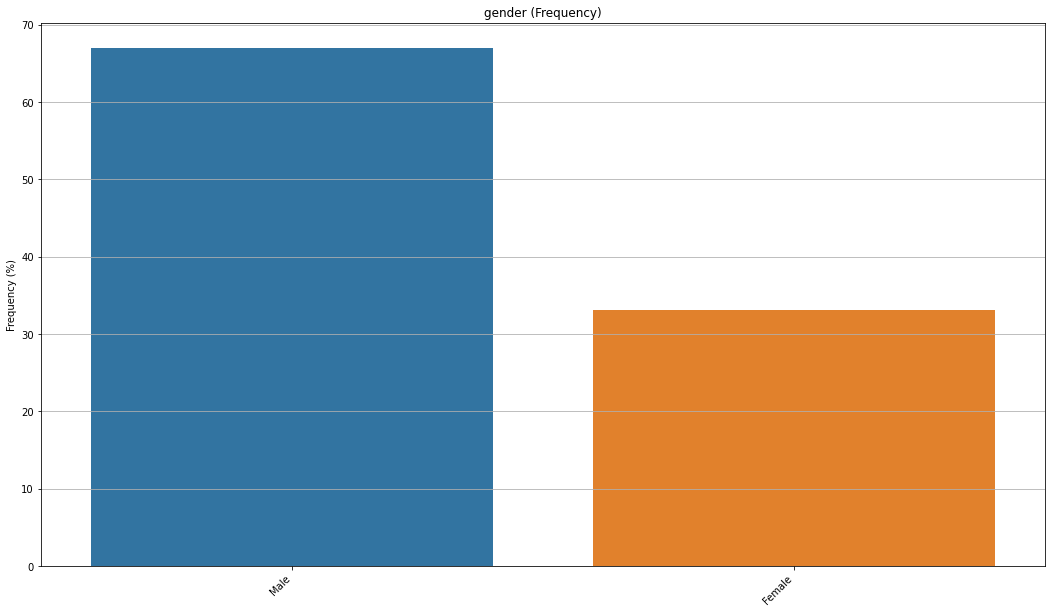

In [94]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'gender').index, y=value_cnt_norm_cal(train_copy,'gender')['Frequency (%)'])
plt.title('gender (Frequency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

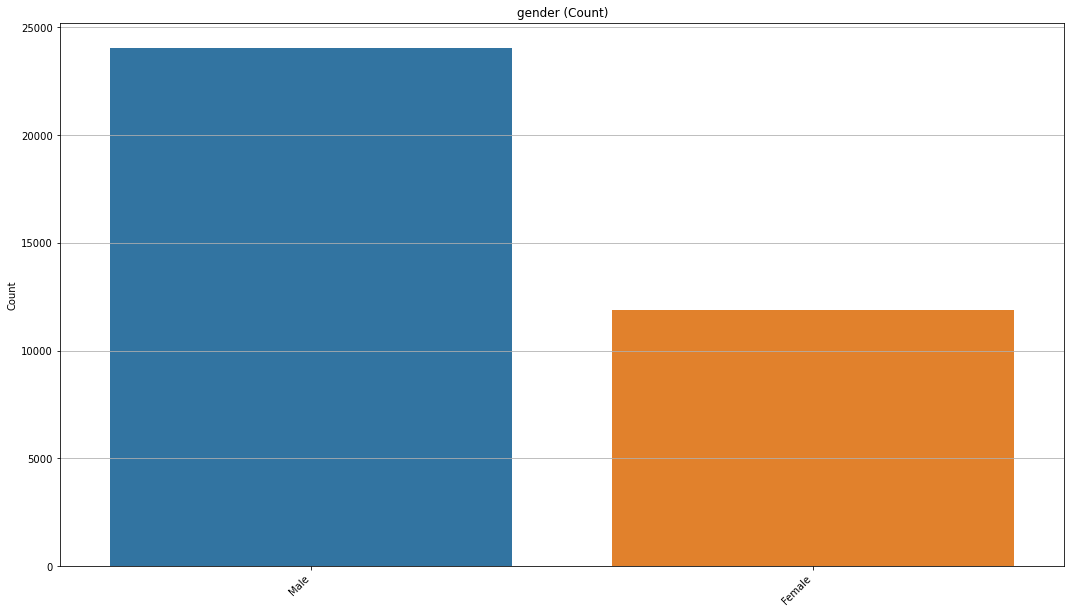

In [95]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'gender').index, y=value_cnt_norm_cal(train_copy,'gender')['Count'])
plt.title('gender (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

In [96]:
# TODO: Gender might influence on the salary. will keep it

### 3.4.11 capital gain

In [97]:
train_copy['capital-gain'].dtype

dtype('int64')

In [98]:
train_copy['capital-gain'].describe()

count   35884.000
mean     1093.011
std      7583.324
min         0.000
25%         0.000
50%         0.000
75%         0.000
max     99999.000
Name: capital-gain, dtype: float64

In [99]:
train_copy['capital-gain'].isnull().sum()

0

In [100]:
train_copy['capital-gain'].value_counts()

0        32939
15024      368
7688       288
7298       273
99999      187
         ...  
1639         1
22040        1
1424         1
6360         1
2036         1
Name: capital-gain, Length: 120, dtype: int64

In [101]:
train_copy['capital-gain'].shape

(35884,)

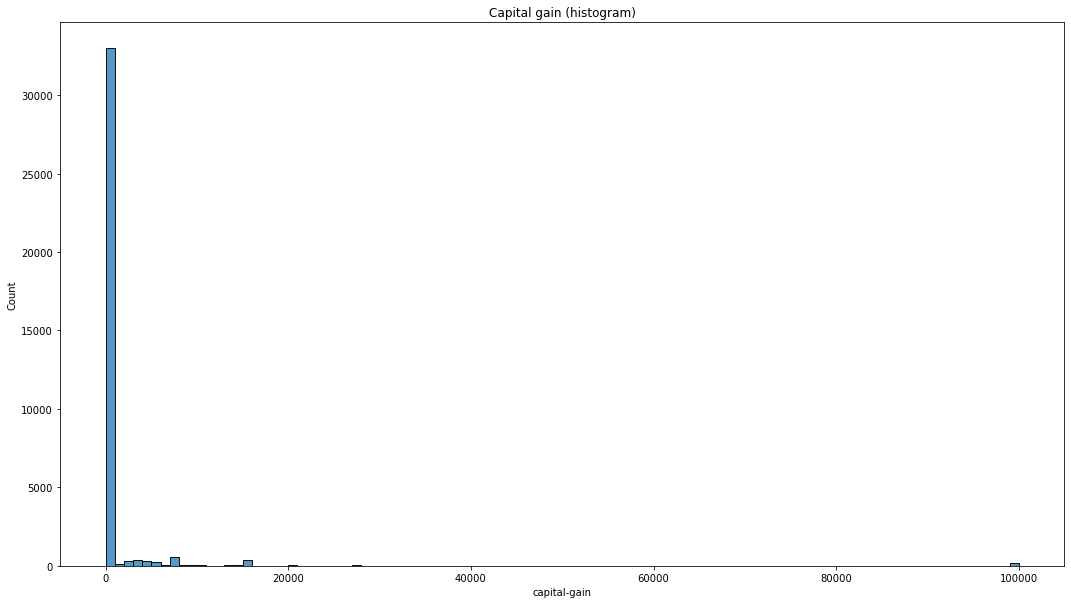

In [102]:
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(train_copy['capital-gain'],bins=100)
plt.title('Capital gain (histogram)')
plt.show()

In [103]:
# TODO: Capital gain is very skewed and contains a lot of zeros. we might need to drop this feature.

### 3.4.12 capital loss

In [104]:
train_copy['capital-loss'].dtype

dtype('int64')

In [105]:
train_copy['capital-loss'].describe()

count   35884.000
mean       88.706
std       406.338
min         0.000
25%         0.000
50%         0.000
75%         0.000
max      4356.000
Name: capital-loss, dtype: float64

In [106]:
train_copy['capital-loss'].isnull().sum()

0

In [107]:
train_copy['capital-loss'].value_counts()

0       34188
1902      217
1977      192
1887      176
1485       56
        ...  
3683        1
810         1
2080        1
155         1
2465        1
Name: capital-loss, Length: 98, dtype: int64

In [108]:
train_copy['capital-loss'].shape

(35884,)

In [109]:
value_cnt_norm_cal(train_copy,'capital-loss')

,Count,Frequency (%)
0,34188,95.274
1902,217,0.605
1977,192,0.535
1887,176,0.490
1485,56,0.156
...,...,...
3683,1,0.003
810,1,0.003
2080,1,0.003
155,1,0.003


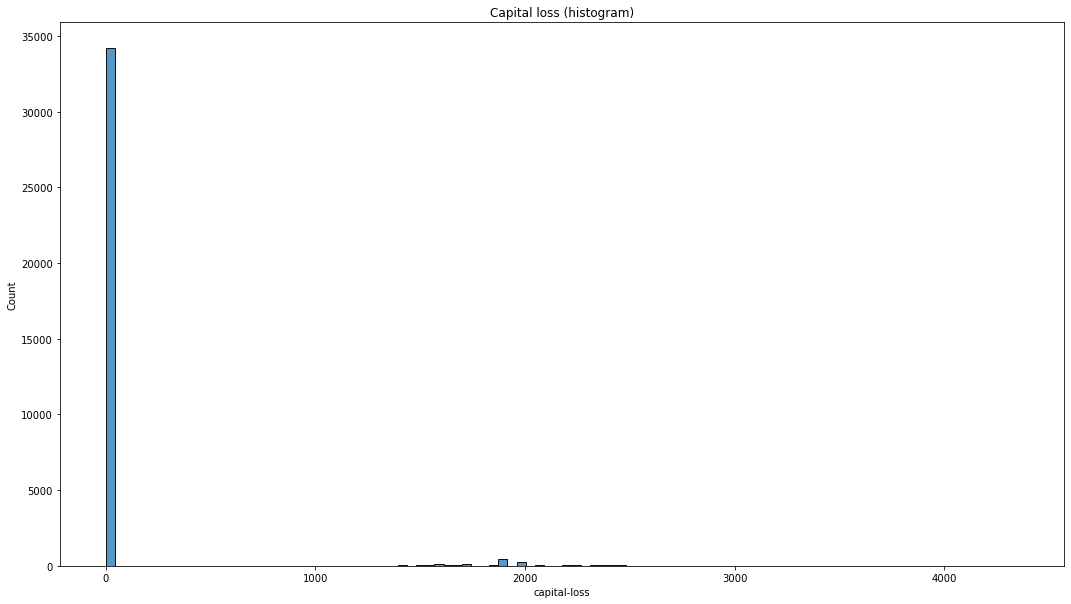

In [110]:
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(train_copy['capital-loss'],bins=100)
plt.title('Capital loss (histogram)')
plt.show()

In [111]:
# TODO: Capital loss is very skewed and contains a lot of zeros. we might need to drop this feature.

### 3.4.13 Hours per week

In [112]:
train_copy['hours-per-week'].dtype

dtype('int64')

In [113]:
train_copy['hours-per-week'].describe()

count   35884.000
mean       40.485
std        12.425
min         1.000
25%        40.000
50%        40.000
75%        45.000
max        99.000
Name: hours-per-week, dtype: float64

In [114]:
value_cnt_norm_cal(train_copy,'hours-per-week')

,Count,Frequency (%)
40,16650,46.400
50,3141,8.753
45,2034,5.668
60,1621,4.517
35,1449,4.038
...,...,...
95,2,0.006
94,1,0.003
82,1,0.003
79,1,0.003


In [115]:
train_copy['hours-per-week'].isnull().sum()

0

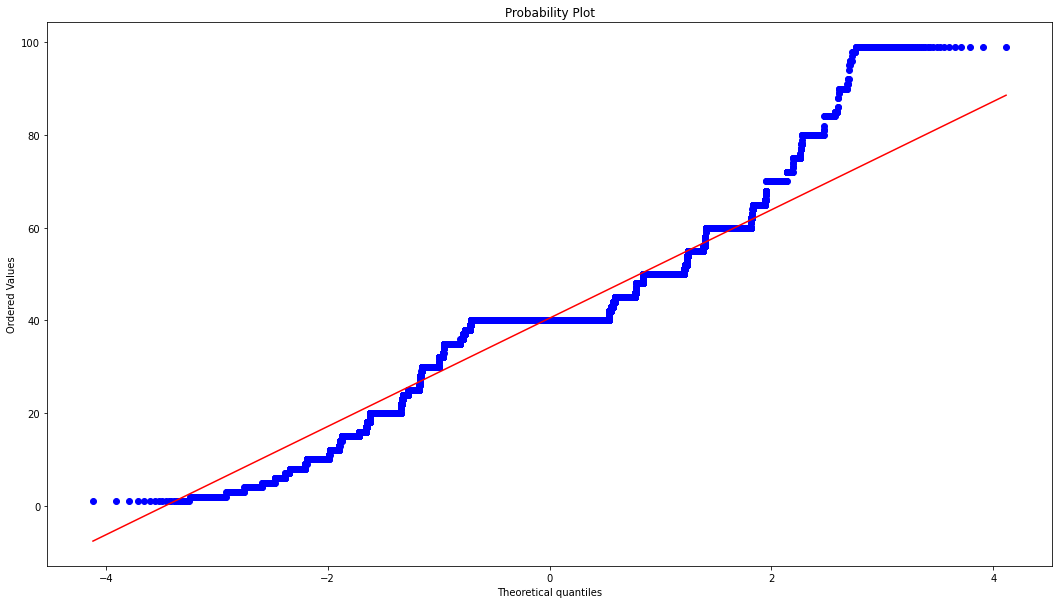

In [116]:
#checking if hours-per-week is normally distributed
fig, ax = plt.subplots(figsize=(18,10))
probplot(train_copy['hours-per-week'], dist="norm", plot=ax)
plt.show()

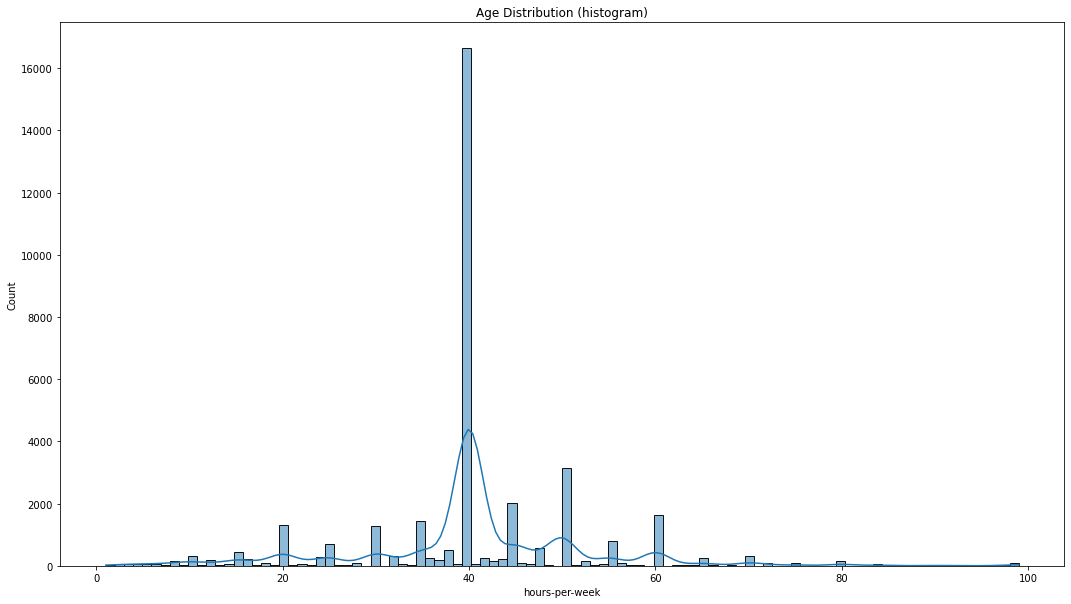

In [117]:
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(train_copy['hours-per-week'],bins=100,kde=True)
plt.title('Age Distribution (histogram)')
plt.show()

In [118]:
# TODO: Hours per week might be useful. will keep it

### 3.4.14 Native country

In [119]:
train_copy['native-country'].dtype

dtype('O')

In [120]:
train_copy['native-country'].isnull().sum()

627

In [121]:
value_cnt_norm_cal(train_copy,'native-country')

,Count,Frequency (%)
United-States,32173,91.253
Mexico,708,2.008
Philippines,220,0.624
Germany,160,0.454
Puerto-Rico,139,0.394
Canada,125,0.355
El-Salvador,114,0.323
Cuba,105,0.298
England,104,0.295
India,102,0.289


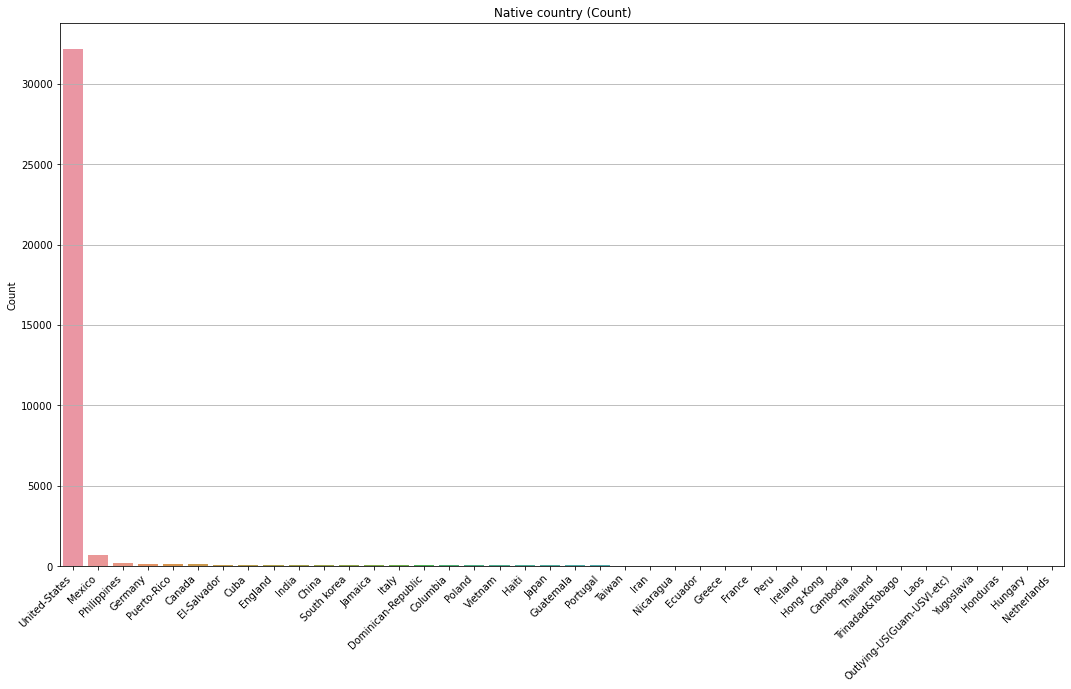

In [122]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'native-country').index, y=value_cnt_norm_cal(train_copy,'native-country')['Count'])
plt.title('Native country (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

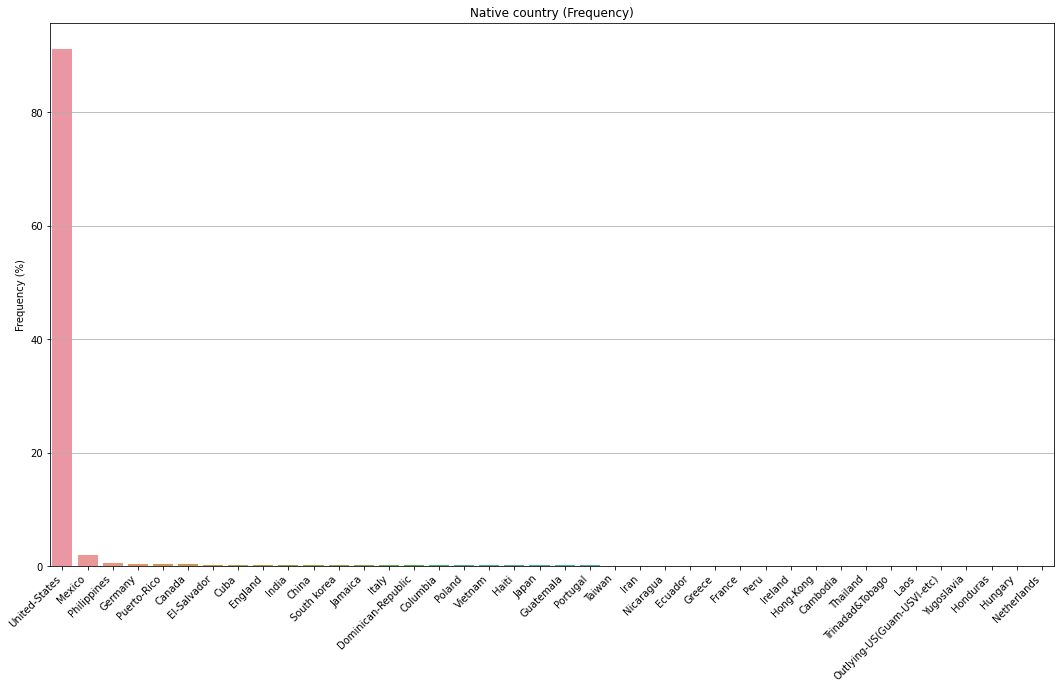

In [123]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'native-country').index, y=value_cnt_norm_cal(train_copy,'native-country')['Frequency (%)'])
plt.title('Native country (Frequency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

In [124]:
# TODO: Native country might be useful but most of the datapoint represent United States. we might need to ingore the other countries.

### 3.4.15 Income > 50 K

In [125]:
train_copy['income_>50K'].dtype

dtype('float64')

In [126]:
train_copy['income_>50K'].isnull().sum()

706

In [127]:
value_cnt_norm_cal(train_copy,'income_>50K')

,Count,Frequency (%)
0.000,26725,75.971
1.000,8453,24.029


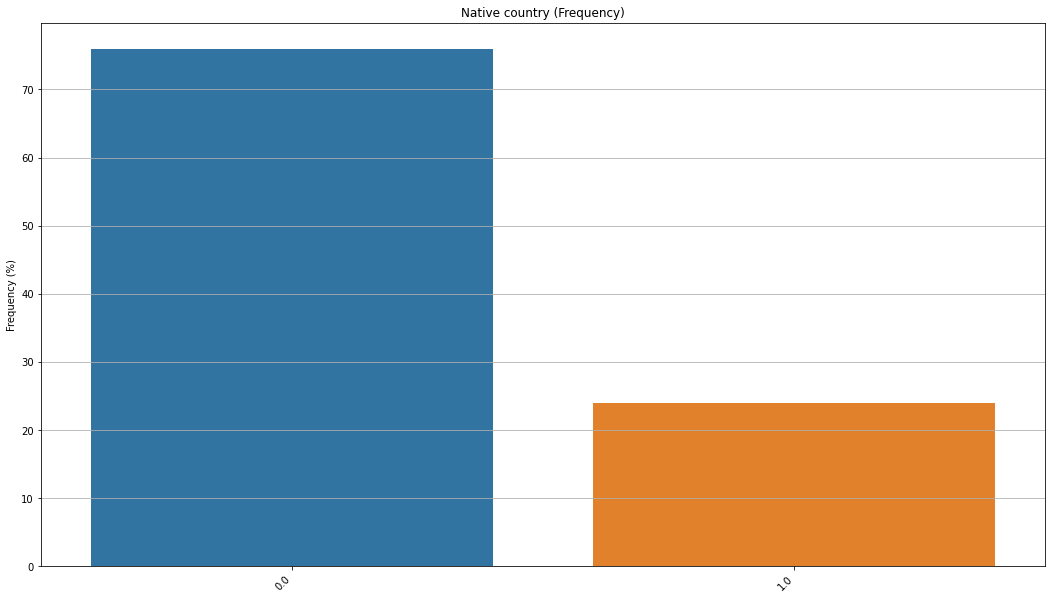

In [128]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'income_>50K').index, y=value_cnt_norm_cal(train_copy,'income_>50K')['Frequency (%)'])
plt.title('Native country (Frequency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()


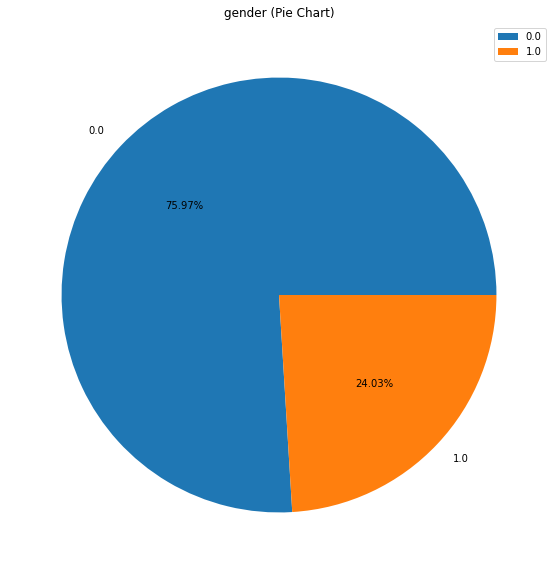

In [129]:
fig, ax = plt.subplots(figsize=(18,10))
plt.pie(train_copy['income_>50K'].value_counts(), labels=train_copy['income_>50K'].value_counts().index, autopct='%1.2f%%')
plt.title('gender (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

In [130]:
# TODO: Our target is imbalance, we will need to oversample before training the model

## 3.5 For supervised learning tasks, identify the target attribute(s).

Tager attribute is the income > 50K

## 3.6 Visualize the data.

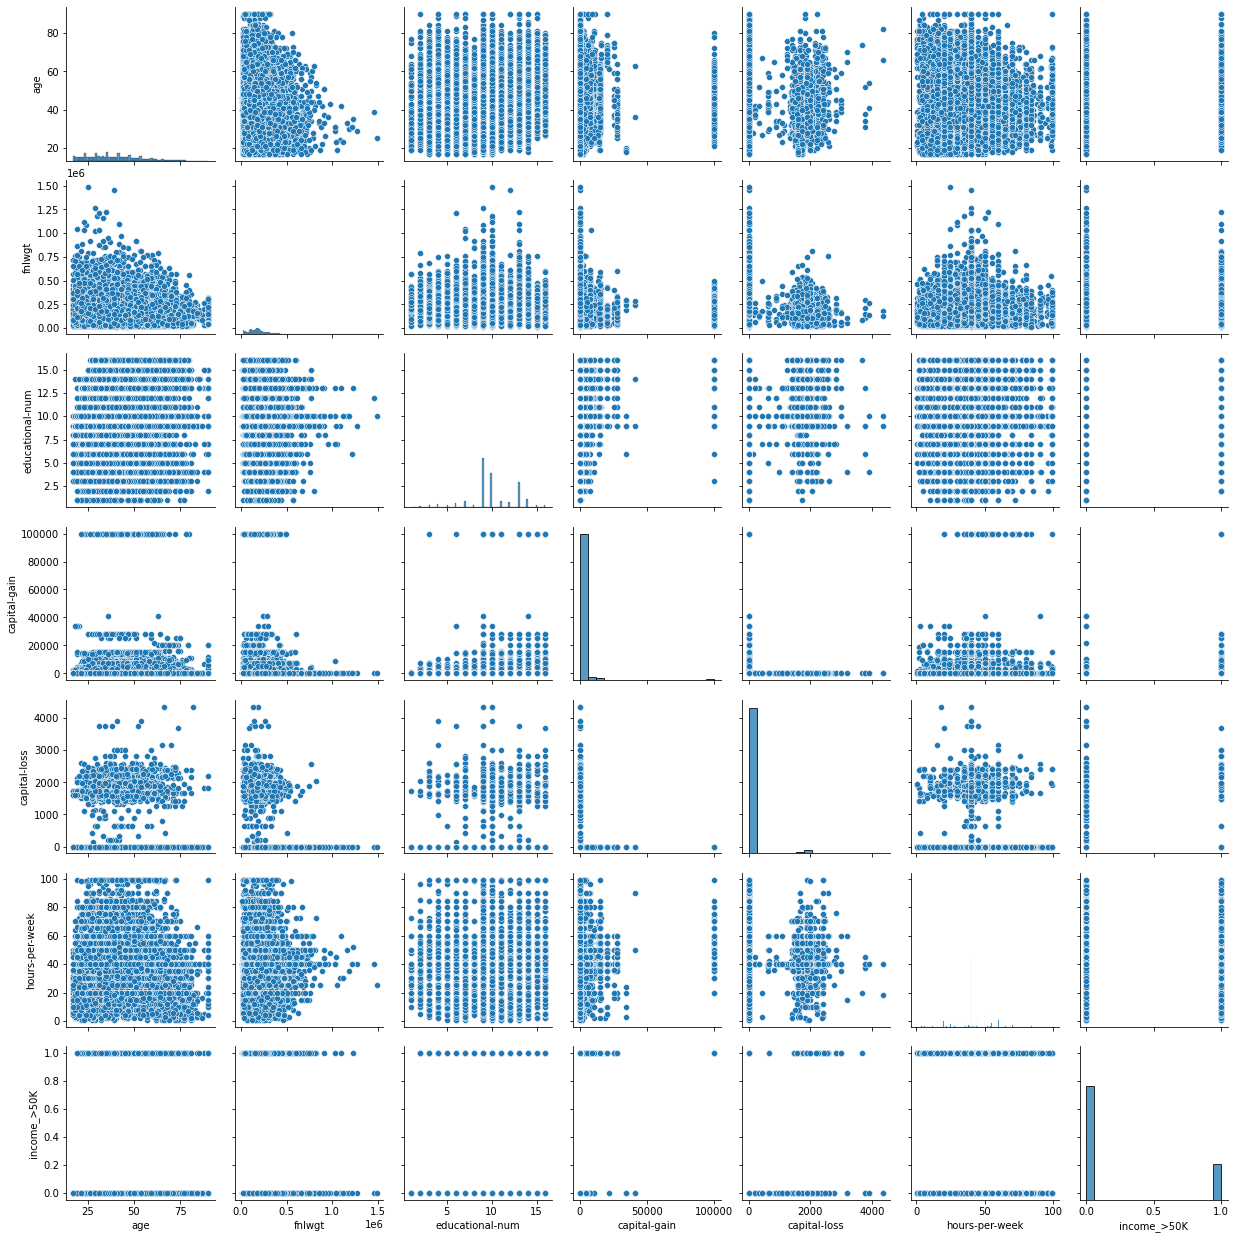

In [131]:
sns.pairplot(train_copy)
plt.show()

## 3.7 Study the pairwise interactions and correlations between attributes.

### 3.7.1 Age vs hours per week (Numerical vs Numerical feature)

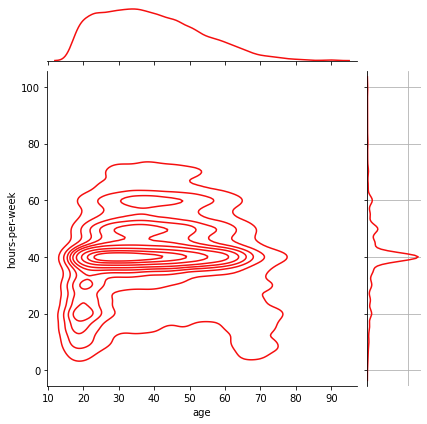

In [132]:
sns.jointplot(x='age', y='hours-per-week', data=train_copy, kind="kde", color="#f50f0f")
plt.grid()
plt.show()

### 3.7.2 Age vs educational number (Numerical vs Numerical feature)

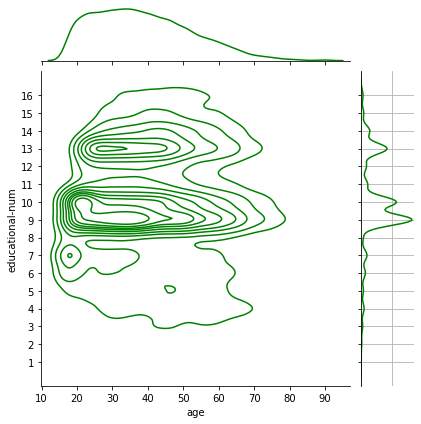

In [133]:
sns.jointplot(x='age', y='educational-num', data=train_copy, kind="kde", color="g")
plt.yticks(np.arange(1, train_copy['educational-num'].nunique()+1, 1))
plt.grid()
plt.show()

In [134]:
education_education_num_relation = pd.DataFrame(train_copy[['education','educational-num']].value_counts()).sort_values(by=['educational-num'], ascending=True).drop([0],axis=1)

In [135]:
education_education_num_relation

,
education,educational-num
Preschool,1
1st-4th,2
5th-6th,3
7th-8th,4
9th,5
10th,6
11th,7
12th,8
HS-grad,9


### 3.7.3 Educational-num vs hours-per-week (Numerical vs Numerical feature)

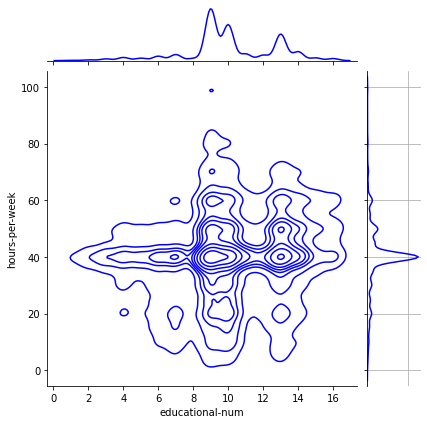

In [136]:
sns.jointplot(x='educational-num', y='hours-per-week', data=train_copy, kind="kde", color="b")
plt.grid()

### 3.7.4 Educational-num vs age (Numerical vs Numerical feature)

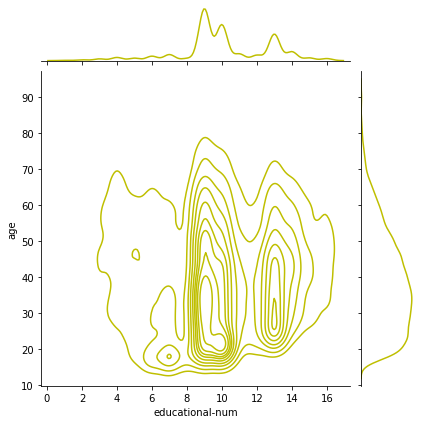

In [137]:
sns.jointplot(x='educational-num', y='age', data=train_copy, kind="kde", color="y")
plt.show()

### 3.7.5 Chi2 test for all the the categorical features (Categorical vs Categorical feature)

In [138]:
def chi2_test(feature_1,feature_2,show_contingency_table=False):
    # creating a cross tabulation of the two features
    feat_1_2_crosstab = pd.crosstab(train_copy[feature_1], train_copy[feature_2])
    stat, p, dof, cont_table = chi2_contingency(feat_1_2_crosstab)
    cont_table_df = pd.DataFrame(cont_table, index=feat_1_2_crosstab.index, columns=feat_1_2_crosstab.columns)
    # toggling the boolean to show the contingency table
    if show_contingency_table:
        print(cont_table_df)
    print('\n')
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
    if abs(stat) >= critical:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    print('\n')
    # interpret p-value
    alpha = 1.0 - prob
    print('significance=%.3f, p=%.3f' % (alpha, p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    # Different implementation of chi2 test

    # df_ft_1 = df[feature_1].dropna(axis=0, how='any')
    # df_ft_2 = df[feature_2].dropna(axis=0, how='any')
    # data_crosstab = pd.crosstab(df_ft_1,df_ft_2,margins=True, margins_name="Total")

    # # significance level
    # alpha = 0.05

    # Calculation of Chisquare test statistics
    # chi_square = 0
    # rows = df_ft_1.unique()
    # columns = df_ft_2.unique()
    # for i in columns:
    #     for j in rows:
    #         O = data_crosstab[i][j]
    #         E = data_crosstab[i]['Total'] * data_crosstab['Total'][j] / data_crosstab['Total']['Total']
    #         chi_square += (O-E)**2/E

    # # The p-value approach
    # print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
    # p_value = 1 - norm.cdf(chi_square, (len(rows)-1)*(len(columns)-1))
    # conclusion = "Failed to reject the null hypothesis."
    # if p_value <= alpha:
    #     conclusion = "Null Hypothesis is rejected."
    # print("chisquare-score is:", chi_square, " and p value is:", p_value)
    # print(conclusion)
    # # The critical value approach
    # print("\n--------------------------------------------------------------------------------------")
    # print("Approach 2: The critical value approach to hypothesis testing in the decision rule")
    # critical_value = chi2.ppf(1-alpha, (len(rows)-1)*(len(columns)-1))
    # conclusion = "Failed to reject the null hypothesis."
    # if chi_square > critical_value:
    #     conclusion = "Null Hypothesis is rejected."
    # print("chisquare-score is:", chi_square, " and p value is:", critical_value)
    # print(conclusion)

In [139]:
all_cat_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income_>50K']

In [140]:
for i in all_cat_features:
    for j in all_cat_features:
        chi2_test(i,j)



probability=0.950, critical=66.339, stat=237356.000
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (reject H0)


probability=0.950, critical=129.918, stat=2501.961
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (reject H0)


probability=0.950, critical=58.124, stat=1244.578
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (reject H0)


probability=0.950, critical=99.617, stat=9360.883
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (reject H0)


probability=0.950, critical=49.802, stat=1375.020
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (reject H0)


probability=0.950, critical=41.337, stat=469.436
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (reject H0)


probability=0.950, critical=14.067, stat=669.113
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (reject H0)


probability=0.950, critical=312.538, stat=538.055
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (re

### 3.7.6 ANOVA test of age vs the rest of categoricals features (Numerical vs continuous feature)

In [141]:
all_cat_features

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'gender',
 'native-country',
 'income_>50K']

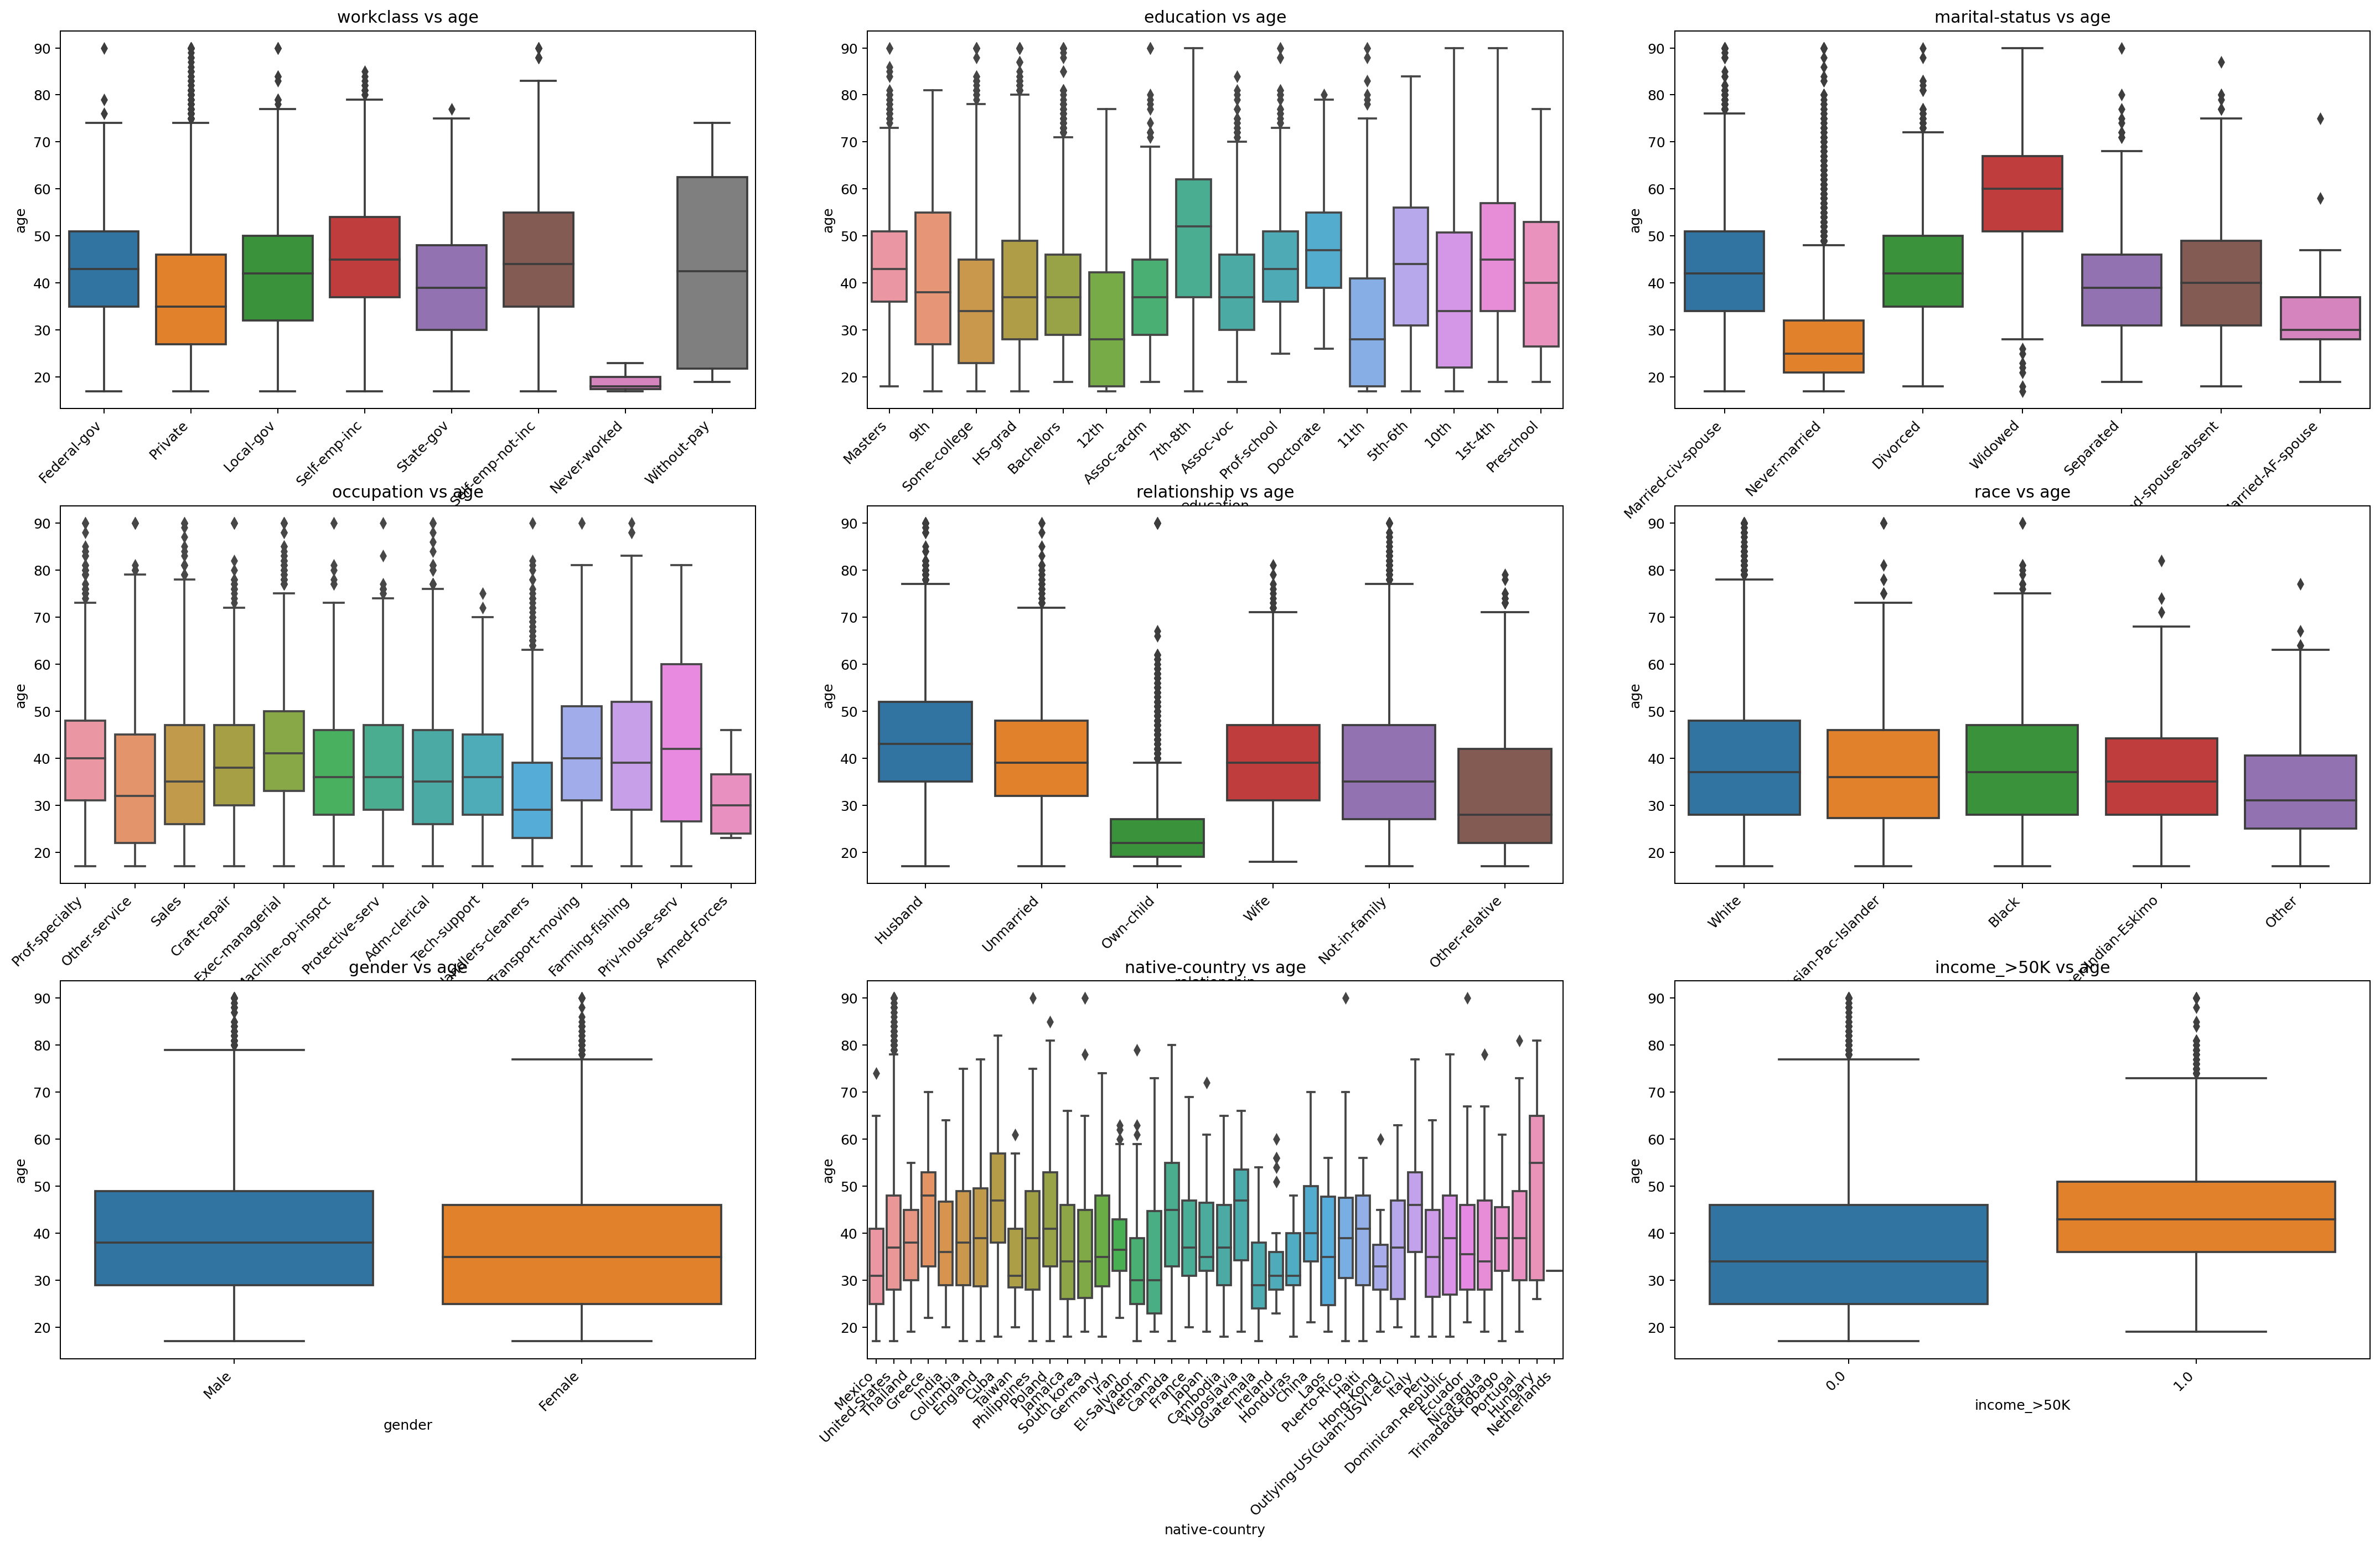

In [142]:
fig, axes = plt.subplots(3,3,figsize=(25,15),dpi=180)
fig.tight_layout(pad=5.0)

for cat_ft_count, ax in enumerate(axes):
    for row_count in range(3):
        for col_count in range(3):
            sns.boxplot(ax=axes[row_count,col_count],x=train_copy[all_cat_features[cat_ft_count]],y=train_copy['age'])
            axes[row_count,col_count].set_title(all_cat_features[cat_ft_count] + " vs age")
            plt.sca(axes[row_count,col_count])
            plt.xticks(rotation=45,ha='right')
            cat_ft_count += 1
    break

### 3.7.7 Correlation between features

In [143]:
train_copy_corr = train_copy.corr()

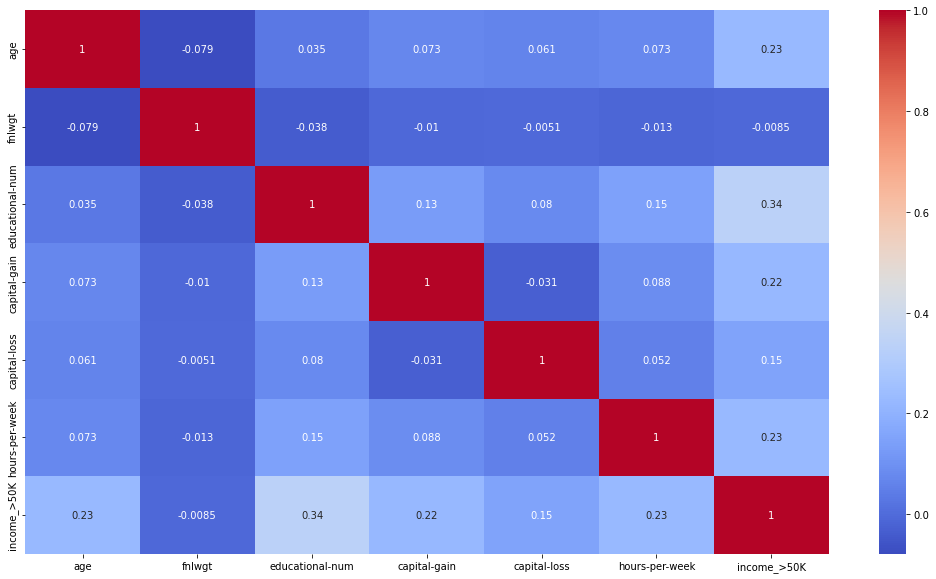

In [144]:
fig, ax = plt.subplots(figsize=(18,10))
sns.heatmap(train_copy_corr, annot=True, cmap='coolwarm')
plt.show()

In [145]:
mask = np.zeros_like(train_copy_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
train_copy_corr[mask] = np.nan
(train_copy_corr
 .style
 .background_gradient(cmap='bwr', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')
)

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,income_>50K
age,nan,nan,nan,nan,nan,nan,nan
fnlwgt,-0.078819,nan,nan,nan,nan,nan,nan
educational-num,0.034910,-0.038337,nan,nan,nan,nan,nan
capital-gain,0.072763,-0.010079,0.128073,nan,nan,nan,nan
capital-loss,0.060755,-0.005127,0.079819,-0.031466,nan,nan,nan
hours-per-week,0.073061,-0.012732,0.146653,0.087716,0.052175,nan,nan
income_>50K,0.227251,-0.008511,0.336798,0.223306,0.149566,0.226075,nan


## 3.8 Study how you would solve the problem manually.

I would look at the correlation between the features and the target variable. the strongest correlation with the target variable is the age, educational-num, capital-gain and hours-per-week.

## 3.9 Identify the promising transformations you may want to apply.

Age:
- Drop outliers
- Min Max Scaling
- Fix skewness

Workclass:
- drop the feature because highly correlated with occupation with less information (To be done after running the model and seeing the feature importance method)
- one hot encoding

Fnwgt:
- drop the feature because there is no correlation with target

Education:
- One hot encoding

Education-num:
- drop the column(because we will use education feature)

Marital-status:
- One hot encoding
- Create a toggle that will use Marital-status, Relation or both to predict income

Occupation:
- One hot encoding
- Handle missing values

Relation:
- One hot encoding
- Create a toggle that will use Marital-status, Relation or both to predict income

Race:
- One hot encoding

Gender:
- One hot encoding

Capital gain:
- Fix skewness
- Min Max Scaling

Capital loss:
- Fix skewness
- Min Max Scaling

Hours per week:
- Min Max Scaling

Native country:
- Groupe countries into 3 GDP Categories (High, Medium, Low GDP)
- drop the feature because we have extracted the 3 GDP categories

GDP Category(extracted from the Native country):
- One hot encoding those categories

Income (Target):
- Fix imbalance data(SMOTE or oversampling)




## 3.10 Identify extra data that would be useful

In [146]:
# GDP data that will be used to group the countries by their GDP
# GDP data of countries in 1990
# Using 1990 data because the Train and test data is an old dataset. How do I know that? One of the country name is Yugoslavia which is no longer since the mid-1990's.
gdp_data = pd.read_csv('datasets/GDP.csv')

In [147]:
gdp_data.sort_values(by='1990' , inplace=True,ascending=False)

In [148]:
gdp_data.reset_index(inplace=True, drop=True)

In [149]:
gdp_data.rename(columns={'Country Name':'native-country','1990':'GDP_1990'},inplace=True)

In [150]:
gdp_data

,native-country,GDP_1990
0,Monaco,84303.880
1,United Arab Emirates,71359.170
2,Brunei,54713.545
3,Liechtenstein,49373.610
4,Luxembourg,29664.795
...,...,...
191,Afghanistan,292.000
192,Mozambique,244.601
193,Eritrea,147.000
194,Somalia,126.920


In [151]:
def add_gdp_data(train_copy,test_copy,gdp_data):
        full_data_copy = pd.concat([train_copy,test_copy],ignore_index=True)
        gdp_group = []
        for idx in gdp_data.index:
            if idx <= 65:
                gdp_group.append('High GDP')
            elif idx >= 65 and idx <= 130:
                gdp_group.append('Medium GDP')
            else:
                gdp_group.append('Low GDP')

        # concatenate the gdp_data with the gdp_group list
        gdp_data = pd.concat([gdp_data.rename(columns={'country':'native-country'}), pd.Series(gdp_group, name='GDP Group')], axis=1)
        # we no longer need the GDP column, so let's drop it
        gdp_data.drop(['GDP_1990'],axis=1,inplace=True)

        # we need to merge the gdp_data with X dataframe
        full_data_copy = pd.merge(full_data_copy, gdp_data, on='native-country', how='left')
        # make income_>50K the last column
        new_col_order = [col for col in full_data_copy.columns if col != 'income_>50K'] + ['income_>50K']
        return full_data_copy[new_col_order]


In [152]:
full_data_copy = add_gdp_data(train_copy,test_copy,gdp_data)

In [153]:
train_copy, test_copy = data_split(full_data_copy,0.2)

## 3.11 Document what you have learned.

All the categorical features are highly correlated (category vs category) and the age and marital status, relationship are highly correlated (numerical vs continuous), finally target is highly correlated with the education, capital gain, age, hour-per-week (numerical vs numerical). 

# 4. Prepare the data for the model

## 4.1 Data cleaning

### 4.1.1 Fix or remove outliers

In [154]:
class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self,col_with_outliers = ['age']):
        self.col_with_outliers = col_with_outliers
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if (set(self.col_with_outliers).issubset(X.columns)):
            Q1 = X[self.col_with_outliers].quantile(.25)
            Q3 = X[self.col_with_outliers].quantile(.75)
            IQR = Q3 - Q1
            outlier_condition = (X[self.col_with_outliers] < (Q1 - 1.5 * IQR)) | (X[self.col_with_outliers] > (Q3 + 1.5 * IQR))
            index_to_keep = X[~outlier_condition.any(axis=1)].index
            return X.loc[index_to_keep]
        else:
            print("Columns not found")
            return X

### 4.1.2 Fill in missing values (e.g., with zero, mean, median...) or drop their rows (or columns).

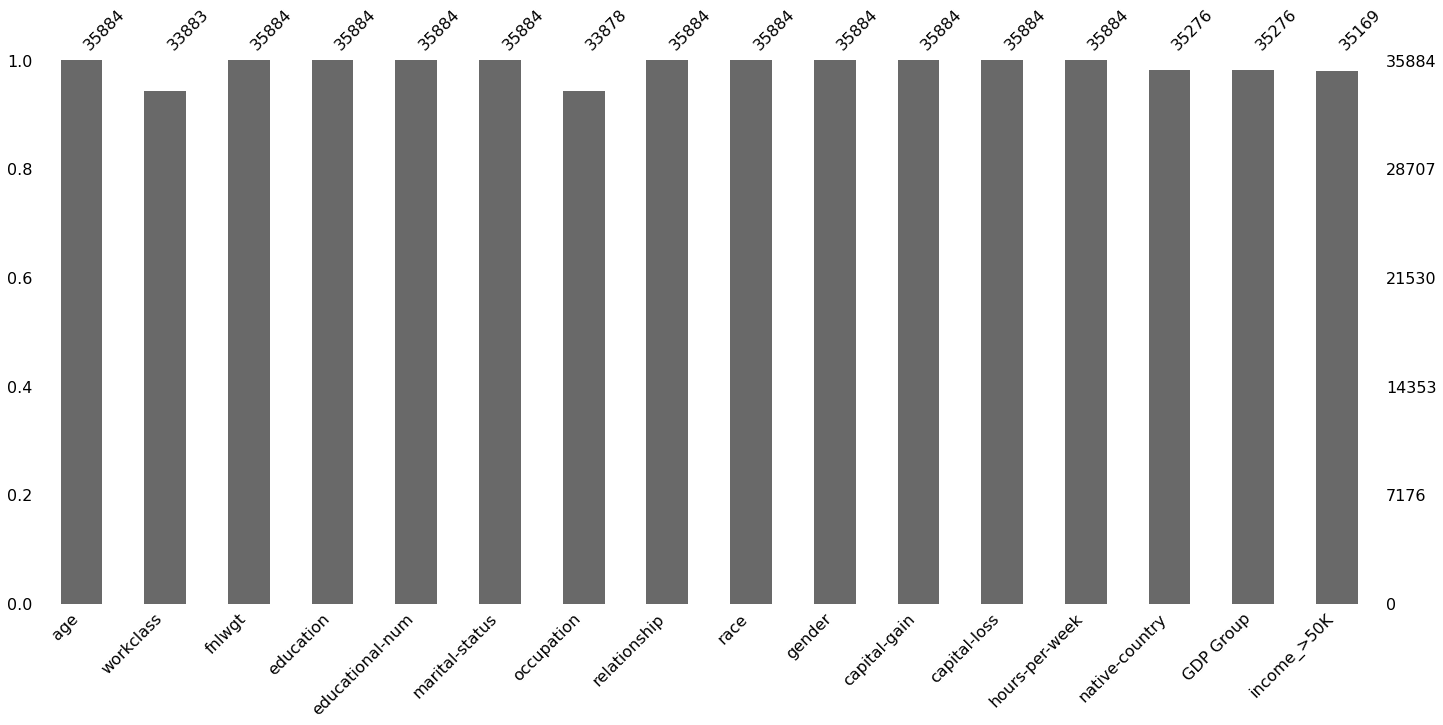

In [155]:
msno.bar(train_copy)
plt.show()

In [156]:
class MissingValHandler(BaseEstimator, TransformerMixin):
    def __init__(self,col_with_nan=['workclass','occupation','native-country','income_>50K']):
        self.col_with_nan = col_with_nan
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if (set(self.col_with_nan).issubset(X.columns)):
            # the occupation that are null with a not null workclass are for people who have never worked. We will impute those observations in the occupation by something more explicit like 'unemployed'.
            workclass_notnull_occ_null_idx = X[(X['workclass'].notnull()) & (X['occupation'].isnull())].index
            # disable chained assignments warning since the function is using X as a copy of the original dataframe
            pd.options.mode.chained_assignment = None
            X['occupation'].iloc[workclass_notnull_occ_null_idx] = 'unemployed'
            X.dropna(inplace=True)
            X.reset_index(inplace=True, drop=True)
            return X
        else:
            print("Columns not found")
            return X

## 4.2 Feature selection

In [157]:
# using the feature importance method from the estimator, drop those features that have a low importance.
# drop_workclass will be called separately after running the model.
# drop_native_country will be called separately after running extraction the GDP group column
class FeatureToDrop(BaseEstimator,TransformerMixin):
    def __init__(self,feature_to_drop = ['fnlwgt','educational-num'], drop_native_country=False, drop_workclass=False, drop_occupation=False):
        self.feature_to_drop = feature_to_drop
        self.drop_native_country = drop_native_country
        self.drop_workclass = drop_workclass
        self.drop_occupation = drop_occupation
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if (set(self.feature_to_drop).issubset(X.columns)):
                X.drop(self.feature_to_drop,axis=1,inplace=True)
                return X
        elif self.drop_native_country:
            self.feature_to_drop.append('native-country')
            if (set(self.feature_to_drop).issubset(X.columns)):
                X.drop(self.feature_to_drop,axis=1,inplace=True)
                return X
            else:
                print("native-country column is not in the dataset")
                return X
        elif self.drop_workclass:
            self.feature_to_drop.append('workclass')
            if (set(self.feature_to_drop).issubset(X.columns)):
                X.drop(self.feature_to_drop,axis=1,inplace=True)
                return X
            else:
                print("workclass column is not in the dataset")
                return X
        elif self.drop_occupation:
            self.feature_to_drop.append('occupation')
            if (set(self.feature_to_drop).issubset(X.columns)):
                X.drop(self.feature_to_drop,axis=1,inplace=True)
                return X
            else:
                print("occupation column is not in the dataset")
                return X
        else:
            print("The features you are trying to drop is not in the dataset")
            return X

## 4.3 Feature Engineering and Transformation

### 4.1.3.1 Marital and relationship status toggle

In [158]:
class DropMaritalOrRelationship(BaseEstimator,TransformerMixin):
    def __init__(self, drop_marital=False, drop_relationship=False):
        self.drop_marital = drop_marital
        self.drop_relationship = drop_relationship
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if self.drop_marital:
            if (set(['marital']).issubset(X.columns)):
                X.drop('marital',axis=1,inplace=True)
                return X
            else:
                print("marital column is not in the dataset")
                return X
        elif self.drop_relationship:
            if (set(['relationship']).issubset(X.columns)):
                X.drop('relationship',axis=1,inplace=True)
                return X
            else:
                print("relationship column is not in the dataset")
                return X
        elif (self.drop_marital) & (self.drop_relationship):
            if (set(['marital','relationship']).issubset(X.columns)):
                X.drop(['marital','relationship'],axis=1,inplace=True)
                return X
            else:
                print("relationship and marital columns are not in the dataset")
                return X
        else:
            print('marital status and relationship are kept in the dataset')
            return X

### 4.1.3.2 Skewness fixings

For more information, refere to [this post](https://medium.com/@TheDataGyan/day-8-data-transformation-skewness-normalization-and-much-more-4c144d370e55)

In [159]:
class SkewnessHandler(BaseEstimator, TransformerMixin):
    def __init__(self,col_with_skewness=['age','capital-gain','capital-loss']):
        self.col_with_skewness = col_with_skewness
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if (set(self.col_with_skewness).issubset(X.columns)):
            # Handle skewness with cubic root transformation
            X[self.col_with_skewness] = np.cbrt(X[self.col_with_skewness])
            return X
        else:
            print('One or more skewed columns are not found')
            return X

### 4.1.3.3 Oversampling with SMOTE

In [160]:
class OversampleSMOTE(BaseEstimator,TransformerMixin):
    def __init__(self, perform_oversampling = True):
        self.perform_oversampling = perform_oversampling
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        # function to oversample the minority class
        if self.perform_oversampling:
            smote = SMOTE()
            X_bal, y_bal = smote.fit_resample(X.iloc[:,:-1],X.iloc[:,-1])
            X_y_bal = pd.concat([pd.DataFrame(X_bal),pd.DataFrame(y_bal)],axis=1)
            return X_y_bal
        else:
            print("No oversampling performed")
            return X

## 4.4 Feature scaling

Will be applied directly in the column transformer/pipeline because they are built in functions

## 4.5 Apply the column transformer and pipeline

In [161]:
def smote_pipeline_fuc(df):
    smote_pipeline = Pipeline([
        ('smote', OversampleSMOTE()) # default: perform_oversampling = True
    ])
    smote_pip_result = smote_pipeline.fit_transform(df)
    return smote_pip_result


In [162]:
def concat_fuc(df_ordinal_minmax, df_onehot, df_target):
    concat_df = pd.concat([df_ordinal_minmax, df_onehot, df_target], axis=1)
    return concat_df

In [163]:
def one_hot_enc_fuc(df):
    columns_to_one_hot_enc = ['race', 'gender']
    columns_to_drop_dict = {'workclass':False, 'occupation':False,'marital-status':False, 'relationship':False, 'native-country':True}
    # loop to add any extra column that was kept to the columns on which will apply the one hot encoding
    for column in columns_to_drop_dict.items():
        if column[1] == False:
            columns_to_one_hot_enc.append(column[0])
    one_hot_enc = OneHotEncoder()
    one_hot_enc.fit(df[columns_to_one_hot_enc])
    # get the result of the one hot encoding columns names
    cols_names_one_hot_enc = one_hot_enc.get_feature_names_out(columns_to_one_hot_enc)
    # change the array of the one hot encoding to a dataframe with the column names
    one_hot_result_with_names_col = pd.DataFrame(one_hot_enc.transform(df[columns_to_one_hot_enc]).toarray(),columns=cols_names_one_hot_enc)
    return one_hot_result_with_names_col

In [164]:
def ordinal_minmax_scaler_fuc(df):
    columns_to_ordinal_enc = ['education', 'GDP Group']
    columns_to_scale = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']
    col_transformer = ColumnTransformer([
    ('Ordinal encoder',OrdinalEncoder(),columns_to_ordinal_enc), # ordinal encoding for education and GDP Group because they are ranked
    ('Min max scaler',MinMaxScaler(),columns_to_scale)]) # scaling for age, capital-gain, capital-loss, hours-per-week
    ordinal_minmax_scaler_result = col_transformer.fit_transform(df)
    ordinal_minmax_scaler_result_with_names_col = pd.DataFrame(ordinal_minmax_scaler_result,columns=columns_to_ordinal_enc+columns_to_scale)
    return ordinal_minmax_scaler_result_with_names_col

In [165]:
def extract_target_col(df):
    target = df.iloc[:,-1].to_frame().reset_index(drop=True)
    return target

In [166]:
def initial_pipeline_fuc(df):
    init_pipeline = Pipeline([
        ('Features to drop', FeatureToDrop()), # default: feature_to_drop = ['fnlwgt','educational-num'], drop_native_country=False, drop_workclass=False, drop_occupation=False
        ('Missing values handler', MissingValHandler()), # drop missing values in the whole dataset
        ('Outliers handler', OutlierHandler()),
        ('Drop marital or relationship', DropMaritalOrRelationship()), # default: drop_marital=False, drop_relationship=False
        ('Skewness handler', SkewnessHandler()), # columns with skewness are 'age','capital-gain','capital-loss'
    ])
    init_pip_result = init_pipeline.fit_transform(df)
    return init_pip_result

In [167]:
def full_pipeline_fuc(df):
    # initial pipeline
    init_pip_result = initial_pipeline_fuc(df)
    #extracting the target variable
    target = extract_target_col(init_pip_result)
    # column transformers to apply ordinal and minmax transformation on specific columns
    ordinal_minmax_result = ordinal_minmax_scaler_fuc(init_pip_result)
    #one hot encoding
    one_hot_enc_result = one_hot_enc_fuc(init_pip_result)
    # concat the result from the ordinal and minmax transformation and one hot encoding with the target variable
    encoded_concat_result = concat_fuc(ordinal_minmax_result,one_hot_enc_result,target)
    # balance the imbalance data with smote function
    smote_pip_result = smote_pipeline_fuc(encoded_concat_result)
    return smote_pip_result

In [168]:
train_copy.head(2)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,GDP Group,income_>50K
0,38,Self-emp-inc,141584,HS-grad,9,Divorced,Sales,Unmarried,White,Male,0,0,55,United-States,High GDP,0.000
1,23,Federal-gov,53245,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,40,United-States,High GDP,0.000


In [169]:
train_copy_prep = full_pipeline_fuc(train_copy)
train_copy_prep.shape
train_copy_prep.head(2)

marital status and relationship are kept in the dataset


,education,GDP Group,age,capital-gain,capital-loss,hours-per-week,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,...,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,income_>50K
0,11.000,0.000,0.480,0.000,0.000,0.551,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
1,9.000,0.000,0.166,0.000,0.000,0.398,0.000,0.000,0.000,0.000,...,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000


In [170]:
train_copy_prep

,education,GDP Group,age,capital-gain,capital-loss,hours-per-week,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,...,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,income_>50K
0,11.000,0.000,0.480,0.000,0.000,0.551,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
1,9.000,0.000,0.166,0.000,0.000,0.398,0.000,0.000,0.000,0.000,...,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
2,12.000,0.000,0.676,0.000,0.000,0.551,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000
3,8.000,0.000,0.367,0.000,0.000,0.398,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
4,15.000,0.000,0.140,0.000,0.000,0.398,0.000,0.000,0.000,0.000,...,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48705,15.000,0.000,0.524,0.000,0.000,0.439,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000
48706,14.000,0.000,0.877,0.000,0.000,0.398,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000
48707,15.000,0.000,0.747,0.000,0.000,0.398,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000
48708,14.596,0.000,0.672,0.215,0.000,0.439,0.000,0.000,1.000,0.000,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000


In [171]:
test_copy_prep = full_pipeline_fuc(test_copy)
test_copy_prep.shape

marital status and relationship are kept in the dataset


(12164, 50)

In [172]:
X_train_copy_prep = train_copy_prep.iloc[:,:-1]
X_train_copy_prep.shape

(48710, 49)

In [173]:
y_train_copy_prep = train_copy_prep.iloc[:,-1]
y_train_copy_prep.shape

(48710,)

In [174]:
X_test_copy_prep = test_copy_prep.iloc[:,:-1]
X_test_copy_prep.shape

(12164, 49)

In [175]:
y_test_copy_prep = test_copy_prep.iloc[:,-1]
y_test_copy_prep.shape

(12164,)

# 5. Shorlist promising models

## 5.0 Functions to evaluate the model

In [176]:
def create_summary_table(summary_data):
    summary_table_col = [
        'Model name',
        'Precision score (Validation set)',
        'Recall score (Validation set)',
        'F1 score (Validation set)',
        'Accuracy score (Validation set)',
        'AUC score (Validation set)',
        'AUC score (Train set)',
        'Has overfit (AUC score (Train set) > AUC score (Validation set))',
        'Confusion matrix',
        'Roc auc curve',
        'Top 10 important features',
        'Top 10 useless features'
        ]
    # no limit for the width of the columns in the dataframe
    pd.set_option('display.max_colwidth', -1)
    summary_df = pd.DataFrame(summary_data, columns=summary_table_col).style.set_properties(subset=['Confusion matrix','Roc auc curve'], **{'width': '432px','height': '432px'})
    # render the dataframe to html so that it can be display the confusion matrix and roc curve image
    summary_df_html = HTML(summary_df.to_html())
    return summary_df_html

In [177]:
def top_and_worst_feat_fuc(col_with_coef):
    top_10_feat, worst_10_feat = col_with_coef[:10], col_with_coef[-10:]
    top_10_feat_str = ""
    worst_10_feat_str = ""
    for count,feat in enumerate(top_10_feat, start=1):
        # top 10 features string formatting
        top_10_feat_str += "{0}. feature name: {1}".format(count,feat[0])+ "<br>" + "coefficient: {:.4f}".format(feat[1]) + "<br>"
    for count,feat in enumerate(worst_10_feat, start=1):
        # worst 10 features string formatting
        worst_10_feat_str += "{0}. feature name: {1}".format(count,feat[0])+ "<br>" + "coefficient: {:.4f}".format(feat[1]) + "<br>"
    return top_10_feat_str, worst_10_feat_str

In [178]:
def check_overfit(auc_score_val_set, auc_score_train_set):
    # if the auc score of the training set is higher than the validation set by more than 0.03, then the model is overfitting
    if (auc_score_train_set - auc_score_val_set) > 0.03:
        return True
    else:
        return False

In [179]:
summary_data = []
def growing_summary_table_fuc(model_name,precision_score,recall_score,f1_score, accuracy_score, auc_score_val_set, auc_score_train_set, is_overfitting, np_img_conf_matrix, np_img_roc_auc, col_with_coef):
    if col_with_coef == 'No coeficient or feature importance for this model':
        each_clf_data = [model_name,precision_score,recall_score,f1_score, accuracy_score, auc_score_val_set, auc_score_train_set, is_overfitting, np_img_conf_matrix, np_img_roc_auc, col_with_coef, col_with_coef]
        summary_data.append(each_clf_data)
    else:
        top_10_feat, worst_10_feat = top_and_worst_feat_fuc(col_with_coef)
        each_clf_data = [model_name,precision_score,recall_score,f1_score, accuracy_score, auc_score_val_set, auc_score_train_set, is_overfitting, np_img_conf_matrix, np_img_roc_auc, top_10_feat, worst_10_feat]
        summary_data.append(each_clf_data)

In [180]:
def roc_curve_fuc(model_trn,model_name,X_train_copy_prep,y_train_copy_prep):
    # path to save the roc curve
    roc_curve_path = Path('saved_preliminary_models/{0}/{0}_roc_curve.jpg'.format(model_name))
    try:
        roc_curve_path.resolve(strict=True)
    except FileNotFoundError:
        print('\n                ROC curve\n')
        lower_than_50k_probs = [0 for _ in range(len(y_train_copy_prep))]
        higher_than_50k_probs = model_trn.predict_proba(X_train_copy_prep)
        higher_than_50k_probs_pos_outcome = higher_than_50k_probs[:,1]
        lower_than_50k_auc = roc_auc_score(y_train_copy_prep,lower_than_50k_probs)
        higher_than_50k_probs_auc = roc_auc_score(y_train_copy_prep,higher_than_50k_probs_pos_outcome)
        #save the auc
        with open('saved_preliminary_models/{0}/lower_than_50k_auc_{0}.pickle'.format(model_name),'wb') as handle:
            pickle.dump(lower_than_50k_auc,handle)
        with open('saved_preliminary_models/{0}/higher_than_50k_probs_auc_{0}.pickle'.format(model_name),'wb') as handle:
            pickle.dump(higher_than_50k_probs_auc,handle)
        # print the auc
        # print('Income lower than 50k: ROC AUC=%.3f' % (lower_than_50k_auc))
        # print('Income higher than 50k: ROC AUC=%.3f' % (higher_than_50k_probs_auc))
        lower_than_50k_false_pos_rate, lower_than_50k_true_pos_rate, _ = roc_curve(y_train_copy_prep,lower_than_50k_probs)
        higher_than_50k_false_pos_rate, higher_than_50k_true_pos_rate, _ = roc_curve(y_train_copy_prep,higher_than_50k_probs_pos_outcome)
        # plt.plot(lower_than_50k_false_pos_rate, lower_than_50k_true_pos_rate, linestyle='--', label='Income lower than 50k')
        # plt.plot(higher_than_50k_false_pos_rate, higher_than_50k_true_pos_rate, marker='.', label='Income higher than 50k')
        # axis labels
        plt.xlabel('False Positive Rate (Fall-Out)')
        plt.ylabel('True Positive Rate (Recall)')
        plt.title('ROC curve')
        # show the legend
        plt.legend()
        # save the plot
        plt.savefig('saved_preliminary_models/{0}/{0}_ROC_curve.jpg'.format(model_name))
        # show the plot
        #plt.show()
        # creating the html roc auc curve image
        img_roc_auc = '<img src="'+ 'saved_preliminary_models/{0}/{0}_ROC_curve.jpg'.format(model_name) + '">'
        return higher_than_50k_probs_auc, img_roc_auc
    else:
        # if roc curve path exists, load the auc first
        with open('saved_preliminary_models/{0}/lower_than_50k_auc_{0}.pickle'.format(model_name),'rb') as handle:
                lower_than_50k_auc = pickle.load(handle)
        with open('saved_preliminary_models/{0}/higher_than_50k_probs_auc_{0}.pickle'.format(model_name),'rb') as handle:
                higher_than_50k_probs_auc = pickle.load(handle)
        # print the auc
        # print('Income lower than 50k: ROC AUC=%.3f' % (lower_than_50k_auc))
        # print('Income higher than 50k: ROC AUC=%.3f' % (higher_than_50k_probs_auc))
        # read the ROC image
        #img_roc = mpimg.imread('saved_preliminary_models/{0}/{0}_ROC_curve.jpg'.format(model_name))
        # plot the ROC image
        #img_roc_plot = plt.imshow(img_roc)
        #remove the axis
        #plt.axis('off')
        # show the plot
        #plt.show()
        # creating the html roc auc curve image
        img_roc_auc = '<img src="'+ 'saved_preliminary_models/{0}/{0}_ROC_curve.jpg'.format(model_name) + '">'
        return higher_than_50k_probs_auc, img_roc_auc


In [181]:
def confusion_matrix_fuc(model_name,y_train_copy_prep,y_train_copy_pred):
    #path to save the confusion matrix
    confusion_matrix_path = Path('saved_preliminary_models/{0}/{0}_confusion_matrix.jpg'.format(model_name))
    try:
        #check if the path exists
        confusion_matrix_path.resolve(strict=True)
    except FileNotFoundError:
        print('\n         Confusion Matrix\n')
        #plot confusion matrix
        confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_train_copy_prep,y_train_copy_pred, cmap='Blues',values_format='d')
        #give a title to the plot using the model name
        plt.title('Confusion Matrix')
        #save the plot as jpg
        plt.savefig('saved_preliminary_models/{0}/{0}_confusion_matrix.jpg'.format(model_name))
        #show the plot
        #plt.show()
        #img_conf_matrix = 'saved_preliminary_models/{0}/{0}_confusion_matrix.jpg'.format(model_name)
        img_conf_matrix_html = '<img src="' + 'saved_preliminary_models/{0}/{0}_confusion_matrix.jpg'.format(model_name) + '">'
        #img_conf_matrix = Image.open('saved_preliminary_models/{0}/{0}_confusion_matrix.jpg'.format(model_name))
        #np_img_conf_matrix = np.array(img_conf_matrix)
        #return np_img_conf_matrix
        return img_conf_matrix_html
    else:
        # plot the confusion matrix image
        img_conf_matrix_html = '<img src="' + 'saved_preliminary_models/{0}/{0}_confusion_matrix.jpg'.format(model_name) + '">'
        # img_conf_matrix = Image.open('saved_preliminary_models/{0}/{0}_confusion_matrix.jpg'.format(model_name))
        # img_conf_matrix_plot = plt.imshow(img_conf_matrix)
        # disable the axis
        # plt.axis('off')
        # plt.show()
        #return np_img_conf_matrix
        return img_conf_matrix_html

In [182]:
def scores_cal_fuc(model_name,X_train_copy_prep,y_train_copy_prep):
    score_list = ['precision','recall','f1','accuracy','roc_auc']
    scores = []
    scores_mean_for_each_type = []
    scores_mean = 0
    scores_std = 0
    # path to save the model folder
    model_dir_path = Path('saved_preliminary_models/{0}/'.format(model_name))
    files_start_with_score_path = []
    #for loop to check if there is any file start with 'score' in the model folder
    for i in os.listdir(model_dir_path):
        if os.path.isfile(os.path.join(model_dir_path,i)) and 'score' in i:
            files_start_with_score_path.append(os.path.join(model_dir_path,i))
    # file that start with 'score' found, load the scores list, mean and std using pickle
    if files_start_with_score_path:
        for score_type in score_list:
            # load the scores list
            with open('saved_preliminary_models/{0}/score_{1}_list.pickle'.format(model_name,score_type),'rb') as handle:
                scores = pickle.load(handle)
            # load the mean score
            with open('saved_preliminary_models/{0}/score_{1}_mean.pickle'.format(model_name,score_type),'rb') as handle:
                scores_mean = pickle.load(handle)
                scores_mean_for_each_type.append(scores_mean)
            # load the std score
            with open('saved_preliminary_models/{0}/score_{1}_std.pickle'.format(model_name,score_type),'rb') as handle:
                scores_std = pickle.load(handle)
            # print('\n                        {} score\n'.format(score_type))
            # print('Scores: {}\n'.format(scores))
            # print('Mean of the scores: {}\n'.format(scores_mean))
            # print('Standard deviation of the scores: {}\n\n'.format(scores_std))
        return scores_mean_for_each_type
    # no file start with score in the model folder
    else:
        for score_type in score_list:
            # calculate the scores for each score type using kfold cross validation
            scores = cross_val_score(model,X_train_copy_prep,y_train_copy_prep,scoring=score_type,cv=10,n_jobs=-1)
            scores_mean = scores.mean()
            scores_mean_for_each_type.append(scores_mean)
            scores_std = scores.std()
            # print('\n                        {} score\n'.format(score_type))
            # print('Scores: {}\n'.format(scores))
            # print('Mean of the scores: {}\n'.format(scores_mean))
            # print('Standard deviation of the scores: {}\n\n'.format(scores_std))
            # save the scores using pickle
            with open('saved_preliminary_models/{0}/score_{1}_list.pickle'.format(model_name,score_type),'wb') as handle:
                pickle.dump(scores,handle)
            # save the mean scores using pickle
            with open('saved_preliminary_models/{0}/score_{1}_mean.pickle'.format(model_name,score_type),'wb') as handle:
                pickle.dump(scores_mean,handle)
            # save the standard deviation scores using pickle
            with open('saved_preliminary_models/{0}/score_{1}_std.pickle'.format(model_name,score_type),'wb') as handle:
                pickle.dump(scores_std,handle)
        return scores_mean_for_each_type

In [183]:
def classification_report_fuc(model_name,y_train_copy_prep,y_train_copy_pred):
    # path to save the classification report
    class_rep_path = Path('saved_preliminary_models/{0}/class_rep_{0}.pickle'.format(model_name))
    try:
        #check if the path exists
        class_rep_path.resolve(strict=True)
    except FileNotFoundError:
        #cross validation prediction with kfold = 10
        #print('\n                Classification Report\n')
        #classification report
        cls_rep = classification_report(y_train_copy_prep,y_train_copy_pred)
        #print(cls_rep)
        # save the classification report
        with open('saved_preliminary_models/{0}/class_rep_{0}.pickle'.format(model_name),'wb') as handle:
            pickle.dump(cls_rep,handle)
        return cls_rep
    else:
        # if it exist load the classification report
        with open('saved_preliminary_models/{0}/class_rep_{0}.pickle'.format(model_name),'rb') as handle:
            cls_rep = pickle.load(handle)
            # print('                       {} Classification Report\n'.format(model_name))
            # print(cls_rep)
            return cls_rep

In [184]:
def load_coef(model_name):
    with open('saved_preliminary_models/{0}/coef_{0}.pickle'.format(model_name),'rb') as handle:
        col_with_coef = pickle.load(handle)
    # print the coefficients of the model
    # print("\nCoefficients for feature importance:\n")
    # [print(i) for i in col_with_coef]
    # print('\n')
    return col_with_coef

In [185]:
def fit_and_save_coef(X_train_copy_prep, coef):
    columns_names = X_train_copy_prep.columns
    col_with_coef = list(zip(columns_names,coef))
    # print("\nCoefficients for feature importance:\n")
    # col_with_coef.sort(key=lambda x: x[1],reverse=True)
    # [print(i) for i in col_with_coef]
    # print('\n')
    # save the coefficients of the model to pickle
    with open('saved_preliminary_models/{0}/coef_{0}.pickle'.format(model_name),'wb') as handle:
        pickle.dump(col_with_coef,handle)
    return col_with_coef

In [186]:
def folder_and_file_model_check(model, model_name, X_train_copy_prep, y_train_copy_prep):
    col_with_coef = []
    # check if the folder with the model name exist and if not create them
    if not os.path.exists('saved_preliminary_models/{}'.format(model_name)):
        os.makedirs('saved_preliminary_models/{}'.format(model_name))
    # check if the model file exist and if not create, train and save it
    model_file_path = Path('saved_preliminary_models/{0}/{0}_model.sav'.format(model_name))
    try:
        model_file_path.resolve(strict=True)
    except FileNotFoundError:
        model_trn = model.fit(X_train_copy_prep,y_train_copy_prep)
        joblib.dump(model_trn,model_file_path)
        # coeficient of the model for feature importance using switch-case statement [new in Python 3.10]
        match model_name:
            # for sgd, logistic regression and linear discriminant analysis, use coef_
            case 'SGD' | 'Logistic_regression' | 'Linear_discriminant_analysis':
                coef_of_each_feat = model_trn.coef_[0]
                col_with_coef = fit_and_save_coef(X_train_copy_prep, coef_of_each_feat)
            #  no coefficients for the svm model as it took a while to train
            case 'Support_vector_machine':
                # no coefficients or feature importance
                col_with_coef = 'No coeficient or feature importance for this model'
                pass
            # for decision tree, random forest, gradient boosting, adaboost and Extra_trees, use feature_importances_
            case 'Decision_tree' | 'Random_forest' | 'Gradient_boosting' | 'AdaBoost' | 'Extra_trees':
                coef_of_each_feat = model_trn.feature_importances_
                col_with_coef = fit_and_save_coef(X_train_copy_prep, coef_of_each_feat)
            # does not have does not offer an intrinsic method to evaluate feature importance. refer to https://stackoverflow.com/questions/62933365/how-to-get-the-feature-importance-in-gaussian-naive-bayes, will use permutation_importance
            case 'Gaussian_naive_bayes':
                imps = permutation_importance(model_trn, X_train_copy_prep, y_train_copy_prep)
                coef_of_each_feat = imps.importances_mean
                col_with_coef = fit_and_save_coef(X_train_copy_prep, coef_of_each_feat)
            # Feature importance is not defined for the KNN Classification algorithm
            case 'K-Nearest_neighbors':
                # no coefficients or feature importance
                col_with_coef = 'No coeficient or feature importance for this model'
                pass
            case 'Bagging':
                coef_of_each_feat = np.mean([tree.feature_importances_ for tree in model_trn.estimators_], axis=0)
                col_with_coef = fit_and_save_coef(X_train_copy_prep, coef_of_each_feat)
            # Feature importance is not defined for the Neural Network Classification algorithm
            case 'Neural_network':
                # no coefficients or feature importance
                col_with_coef = 'No coeficient or feature importance for this model'
                pass

    else:
        # if it exist load the model
        model_trn = joblib.load(model_file_path)
        # load the coefficients of the model from pickle
        match model_name:
            case 'SGD' | 'Logistic_regression' | 'Linear_discriminant_analysis':
                col_with_coef = load_coef(model_name)
            case 'Support_vector_machine':
                col_with_coef = 'No coeficient or feature importance for this model'
                pass
            case 'Decision_tree' | 'Random_forest' | 'Gradient_boosting' | 'AdaBoost' | 'Extra_trees':
                col_with_coef = load_coef(model_name)
            case 'Gaussian_naive_bayes':
                col_with_coef = load_coef(model_name)
            case 'K-Nearest_neighbors':
                col_with_coef = 'No coeficient or feature importance for this model'
                pass
            case 'Bagging':
                col_with_coef = load_coef(model_name)
            case 'Neural_network':
                col_with_coef = 'No coeficient or feature importance for this model'
                pass
    # check if y_train_copy_prep exist and if not create it
    y_train_copy_pred_path = Path('saved_preliminary_models/{0}/y_train_copy_pred_{0}.sav'.format(model_name))
    try:
        y_train_copy_pred_path.resolve(strict=True)
    except FileNotFoundError:
        #cross validation prediction with kfold = 10
        y_train_copy_pred = cross_val_predict(model_trn,X_train_copy_prep,y_train_copy_prep,cv=10,n_jobs=-1)
        #save the predictions
        joblib.dump(y_train_copy_pred,y_train_copy_pred_path)
        return y_train_copy_pred, model_trn, col_with_coef
    else:
        # if it exist load the predictions
        y_train_copy_pred = joblib.load(y_train_copy_pred_path)
        return y_train_copy_pred, model_trn, col_with_coef

In [187]:
def evaluate_model(model,model_name,X_train_copy_prep,y_train_copy_prep):
    #print('\n       ***************  {}  ***************\n'.format(model_name))
    # create the folder and the model file if they don't exist
    y_train_copy_pred,model_trn, col_with_coef = folder_and_file_model_check(model,model_name,X_train_copy_prep,y_train_copy_prep)
    # return the classification report
    classification_report_fuc(model_name,y_train_copy_prep,y_train_copy_pred)
    # print the scores by score type, mean scores and std scores and return the mean scores
    scores_mean= scores_cal_fuc(model_name,X_train_copy_prep,y_train_copy_prep)
    # return the confusion matrix
    img_conf_matrix = confusion_matrix_fuc(model_name,y_train_copy_prep,y_train_copy_pred)
    # return the ROC curve and numpy array of image auc and roc curve
    auc_score_train, img_roc_auc  = roc_curve_fuc(model_trn,model_name,X_train_copy_prep,y_train_copy_prep)
    # check if the model has overfit
    is_overfitting = check_overfit(scores_mean[4],auc_score_train)
    # create a comparison summary table
    growing_summary_table_fuc(model_name, scores_mean[0], scores_mean[1], scores_mean[2], scores_mean[3], scores_mean[4], auc_score_train, is_overfitting, img_conf_matrix, img_roc_auc, col_with_coef)

## 5.1 Quick models comparison

In [188]:
model_dict = {
    'SGD':SGDClassifier(random_state=42,loss='log'),
    'Logistic_regression':LogisticRegression(random_state=42,max_iter=1000),
    'Support_vector_machine':SVC(random_state=42,probability=True),
    'Decision_tree':DecisionTreeClassifier(random_state=42),
    'Random_forest':RandomForestClassifier(random_state=42),
    'Gaussian_naive_bayes':GaussianNB(),
    'K-Nearest_neighbors':KNeighborsClassifier(),
    'Gradient_boosting':GradientBoostingClassifier(random_state=42),
    'Linear_discriminant_analysis':LinearDiscriminantAnalysis(),
    'Bagging':BaggingClassifier(random_state=42),
    'Neural_network':MLPClassifier(random_state=42,max_iter=1000),
    'AdaBoost':AdaBoostClassifier(random_state=42),
    'Extra_trees':ExtraTreesClassifier(random_state=42),
}

In [189]:
for model_name,model in model_dict.items():
    evaluate_model(model,model_name,X_train_copy_prep,y_train_copy_prep)

In [190]:
create_summary_table(summary_data)

,Model name,Precision score (Validation set),Recall score (Validation set),F1 score (Validation set),Accuracy score (Validation set),AUC score (Validation set),AUC score (Train set),Has overfit (AUC score (Train set) > AUC score (Validation set)),Confusion matrix,Roc auc curve,Top 10 important features,Top 10 useless features
0,SGD,0.793223,0.834383,0.811048,0.806574,0.893404,0.892416,False,,,1. feature name: capital-gaincoefficient: 5.08372. feature name: gender_Malecoefficient: 4.76623. feature name: gender_Femalecoefficient: 3.86564. feature name: hours-per-weekcoefficient: 3.44745. feature name: marital-status_Married-civ-spousecoefficient: 3.18386. feature name: relationship_Wifecoefficient: 2.65907. feature name: agecoefficient: 2.28258. feature name: occupation_Prof-specialtycoefficient: 2.27959. feature name: race_Asian-Pac-Islandercoefficient: 2.260010. feature name: race_Whitecoefficient: 2.1644,1. feature name: occupation_Armed-Forcescoefficient: 0.18442. feature name: occupation_Machine-op-inspctcoefficient: 0.13263. feature name: educationcoefficient: 0.05084. feature name: workclass_Never-workedcoefficient: -0.00125. feature name: occupation_unemployedcoefficient: -0.00126. feature name: occupation_Farming-fishingcoefficient: -0.23147. feature name: GDP Groupcoefficient: -0.31278. feature name: occupation_Other-servicecoefficient: -0.42209. feature name: occupation_Handlers-cleanerscoefficient: -0.425510. feature name: occupation_Priv-house-servcoefficient: -0.8108
1,Logistic_regression,0.796645,0.840265,0.817856,0.812868,0.894018,0.894491,False,,,1. feature name: capital-gaincoefficient: 5.12042. feature name: hours-per-weekcoefficient: 3.29503. feature name: agecoefficient: 2.12144. feature name: marital-status_Married-civ-spousecoefficient: 1.63165. feature name: occupation_Prof-specialtycoefficient: 1.61366. feature name: marital-status_Married-AF-spousecoefficient: 1.44357. feature name: capital-losscoefficient: 1.42168. feature name: occupation_Exec-managerialcoefficient: 1.32989. feature name: relationship_Wifecoefficient: 1.166610. feature name: occupation_Tech-supportcoefficient: 0.9705,1. feature name: marital-status_Widowedcoefficient: -0.63412. feature name: race_Amer-Indian-Eskimocoefficient: -0.67143. feature name: marital-status_Never-marriedcoefficient: -0.67684. feature name: relationship_Own-childcoefficient: -0.84205. feature name: marital-status_Separatedcoefficient: -0.84276. feature name: occupation_Farming-fishingcoefficient: -0.84447. feature name: relationship_Other-relativecoefficient: -0.93018. feature name: occupation_Other-servicecoefficient: -0.98389. feature name: occupation_Handlers-cleanerscoefficient: -0.988210. feature name: occupation_Priv-house-servcoefficient: -1.9372
2,Support_vector_machine,0.777492,0.846642,0.810571,0.802151,0.887308,0.888632,False,,,No coeficient or feature importance for this model,No coeficient or feature importance for this model
3,Decision_tree,0.850169,0.834961,0.839757,0.844915,0.858088,0.999057,True,,,1. feature name: marital-status_Married-civ-spousecoefficient: 0.29392. feature name: agecoefficient: 0.18363. feature name: hours-per-weekcoefficient: 0.12164. feature name: educationcoefficient: 0.09345. feature name: capital-gaincoefficient: 0.08986. feature name: capital-losscoefficient: 0.02007. feature name: occupation_Exec-managerialcoefficient: 0.01668. feature name: occupation_Prof-specialtycoefficient: 0.01639. feature name: workclass_Privatecoefficient: 0.012510. feature name: occupation_Salescoefficient: 0.0118,1. feature name: relationship_Other-relativecoefficient: 0.00102. feature name: race_Othercoefficient: 0.00093. feature name: marital-status_Married-spouse-absentcoefficient: 0.00084. feature name: marital-status_Widowedcoefficient: 0.00075. feature name: marital-status_Married-AF-spousecoefficient: 0.00026. feature name: workclass_Without-paycoefficient: 0.00007. feature name: workclass_Never-workedcoefficient: 0.00008. feature nam

## 5.3. Analyze the most significant variables for each algorithm.
### (For each model, use N-fold cross-validation and compute the mean and standard deviation of the performance measure on the N folds)

Done in quick models comparison

## 5.4 Analyze the types of errors the models make.

Done! the algorithms with coeffiecients and feature importance have been evaluated in quick model comparison.